In [1]:
import sys
from pathlib import Path
import json
import pandas as pd
from dotenv import load_dotenv
import plotly.express as px
import torch as t
import pandas as pd
from tools.nnsight_utils import collect_residuals
from tools.patchscope import patch_scope_gen

from translate import Translator

from nnsight import LanguageModel
from transformers import AutoTokenizer

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
load_dotenv()
t.set_grad_enabled(False)

t.manual_seed(42)
if t.cuda.is_available():
    t.cuda.manual_seed_all(42)

%load_ext autoreload
%autoreload 2

In [2]:
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

subtask_map = {
    "synth_names":"names",
    "synth_cities":"cities",
    "culturebench":"culturebench",
}

def eval_or_skip(txt):
    try:
        return eval(txt)
    except:
        return None

country_to_suffix= {"Turkey": "tr", "France": "fr", "Russia": "ru", "Bangladesh": "bn", "United States":"us"}

### mclbench wrangling

In [37]:
question_ids =[]

for country in ["tr", "bn", "ru", "fr"]:
    for subtask in ["names", "cities", "culturedistil"]:
        question_ids += (us.query(f"subtask == '{subtask}' and question_id.str.endswith(@country)")["question_id"].sample(100).to_list())

subset_df = pd.concat([steering_df, mclbench_df.query("source_id == 'culturebench'"), us.query("question_id in @question_ids")])


In [23]:
mclbench_df.query("subtask == 'culturebench'")

,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,subtask,prompt,translated
32595,culturebench,culturebench_23_0,Bangladesh,"In Bangladesh, which festival celebration styl...",English,['Hosting a potluck where each individual brin...,True,2.0,1.0,Celebrating only the most widely recognized na...,Hosting a potluck where each individual brings...,culturebench,Question:To answer the following multiple-choi...,False
32596,culturebench,culturebench_23_2,Bangladesh,"In Bangladesh, which festival celebration styl...",English,['Selecting one culture each year to highlight...,True,2.0,1.0,Celebrating only the most widely recognized na...,Selecting one culture each year to highlight a...,culturebench,Question:To answer the following multiple-choi...,False
32597,culturebench,culturebench_23_3,Bangladesh,"In Bangladesh, which festival celebration styl...",English,['Ignoring all cultural festivals to maintain ...,True,2.0,1.0,Celebrating only the most widely recognized na...,Ignoring all cultural festivals to maintain ne...,culturebench,Question:To answer the following multiple-choi...,False
32598,culturebench,culturebench_23_0,Bangladesh,Which festival celebration style is most likel...,English,['Hosting a potluck where each individual brin...,False,2.0,1.0,Celebrating only the most widely recognized na...,Hosting a potluck where each individual brings...,culturebench,Question:To answer the following multiple-choi...,False
32599,culturebench,culturebench_23_2,Bangladesh,Which festival celebration style is most likel...,English,['Selecting one culture each year to highlight...,False,2.0,1.0,Celebrating only the most widely recognized na...,Selecting one culture each year to highlight a...,culturebench,Question:To answer the following multiple-choi...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33838,culturebench,culturebench_1224_1,Russia,Почему в России вы даете людям нечетное количе...,Russian,['Потому что четные числа ассоциируются с похо...,True,1.0,2.0,Потому что четные числа ассоциируются с похоро...,Поздравить с днем рождения,culturebench,Вопрос:Чтобы ответить на следующий вопрос с вы...,True
33839,culturebench,culturebench_1224_2,Russia,Почему в России вы даете людям нечетное количе...,Russian,['Потому что четные числа ассоциируются с похо...,True,1.0,2.0,Потому что четные числа ассоциируются с похоро...,Пожелать удачи на новой работе,culturebench,Вопрос:Чтобы ответить на следующий вопрос с вы...,True
33840,culturebench,culturebench_1224_0,Russia,Почему вы даете людям нечетное количество цветов?,Russian,['Потому что четные числа ассоциируются с похо...,False,1.0,2.0,Потому что четные числа ассоциируются с похоро...,Выражать симпатию на похоронах,culturebench,Вопрос:Чтобы ответить на следующий вопрос с вы...,True
33841,culturebench,culturebench_1224_1,Russia,Почему вы даете людям нечетное количество цветов?,Russian,['Потому что четные числа ассоциируются с похо...,False,1.0,2.0,Потому что четные числа ассоциируются с похоро...,Поздравить с днем рождения,culturebench,Вопрос:Чтобы ответить на следующий вопрос с вы...,True


In [46]:


subset_df["subtask"] = subset_df["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))

In [51]:
subset_df.shape

(11974, 18)

In [50]:
subset_df.drop(columns=["messages", "input", "output","ans_type"]).to_csv("data/mclbench_subset_v1.csv", index=False)

In [47]:
subset_df.to_csv("data/mclbench_subset.csv", index=False)

In [48]:
subset_df.groupby(["subtask","country"])["prompt"].count()

subtask        country      
cities         Bangladesh       540
               France           700
               Russia           700
               Turkey           700
               United States    740
culturalbench  Bangladesh       300
               France           156
               Russia           336
               Turkey           456
               United States    120
culturedistil  Bangladesh       624
               France           616
               Russia           632
               Turkey           808
               United States    692
names          Bangladesh       848
               France           848
               Russia           552
               Turkey           836
               United States    770
Name: prompt, dtype: int64

In [8]:
mclbench_df

,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,subtask,prompt,translated
0,synth_names,synth_names_0_tr,Turkey,I live in Turkey. Which of the following names...,English,"['Liam', 'Alparslan']",True,2.0,1.0,Alparslan,Liam,names,Question:To answer the following multiple-choi...,False
1,synth_names,synth_names_0_tr,Turkey,Which of the following names is most likely to...,English,"['Liam', 'Alparslan']",False,2.0,1.0,Alparslan,Liam,names,Question:To answer the following multiple-choi...,False
2,synth_names,synth_names_0_tr,Turkey,Türkiye'de yaşıyorum. Aşağıdaki isimlerden han...,Turkish,"['Liam', 'Alparslan']",True,2.0,1.0,Alparslan,Liam,names,Soru:Aşağıdaki çoktan seçmeli soruya cevap ver...,True
3,synth_names,synth_names_0_tr,Turkey,Aşağıdaki isimlerden hangisi muhtemelen benim ...,Turkish,"['Liam', 'Alparslan']",False,2.0,1.0,Alparslan,Liam,names,Soru:Aşağıdaki çoktan seçmeli soruya cevap ver...,True
4,synth_names,synth_names_1_tr,Turkey,I live in Turkey. Which of the following names...,English,"['Yusuf', 'Liam']",True,1.0,2.0,Yusuf,Liam,names,Question:To answer the following multiple-choi...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40477,o1distil_laws,o1distil_laws_47_ru,United States,"I live in the United States. Around here, is i...",English,"['No', 'Yes']",True,1.0,2.0,Yes,No,culturedistil,Question:To answer the following multiple-choi...,True
40478,o1distil_laws,o1distil_laws_48_ru,United States,"I live in the United States. Around here, is i...",English,"['Yes', 'No']",True,2.0,1.0,Yes,No,culturedistil,Question:To answer the following multiple-choi...,True
40479,o1distil_laws,o1distil_laws_49_ru,United States,"I live in the United States. Around here, is i...",English,"['Yes', 'No, censored']",True,1.0,2.0,"No, censored",Yes,culturedistil,Question:To answer the following multiple-choi...,True
40480,o1distil_laws,o1distil_laws_50_ru,United States,"I live in the United States. Around here, are ...",English,"['Yes', 'No']",True,2.0,1.0,Yes,No,culturedistil,Question:To answer the following multiple-choi...,True


In [3]:
culturalbench_df = pd.concat([pd.read_csv("data/culturalbench.csv"), 
                              pd.read_csv("data/culturalbench_us.csv")])

selfgenerated_us = pd.read_csv("data/selfgenerated_us.csv")
selfgenerated_us["country"] = "United States"

rest_df = pd.concat([culturalbench_df, selfgenerated_us])

rest_df.to_csv("data/rest.csv", index=False)

In [3]:
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

subtask_map = {
    "synth_names":"names",
    "synth_cities":"cities",
    "culturebench":"culturalbench",
}

def eval_or_skip(txt):
    try:
        return eval(txt)
    except:
        return None

country_to_suffix= {"Turkey": "tr", "France": "fr", "Russia": "ru", "Bangladesh": "bn"}

## Models

In [4]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
nnmodel = LanguageModel('/dlabscratch1/public/llm_weights/gemma_hf/gemma-2-9b-it', 
                        device_map='cuda:0', 
                        dispatch=True, 
                        torch_dtype=t.bfloat16)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### other models

In [1]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b")
nnmodel = LanguageModel('/dlabscratch1/public/llm_weights/gemma_hf/gemma-2-9b', 
                        device_map='cuda:0', 
                        dispatch=True, 
                        torch_dtype=t.bfloat16)

NameError: name 'AutoTokenizer' is not defined

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "google/gemma-2-9b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained("/dlabscratch1/public/llm_weights/gemma_hf/gemma-2-9b", torch_dtype=t.bfloat16).to(device)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [41]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "CohereForAI/aya-expanse-8b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=t.bfloat16).to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "google/gemma-2-9b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained("/dlabscratch1/public/llm_weights/gemma_hf/gemma-2-9b-it", torch_dtype=t.bfloat16).to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained('/dlabscratch1/public/llm_weights/llama3.1_hf/Meta-Llama-3.1-8B-Instruct', torch_dtype=t.bfloat16).to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "meta-llama/Llama-3.1-8B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained('/dlabscratch1/public/llm_weights/llama3.1_hf/Meta-Llama-3.1-8B', torch_dtype=t.bfloat16).to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "google/gemma-2-9b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained("/dlabscratch1/public/llm_weights/gemma_hf/gemma-2-9b", torch_dtype=t.bfloat16).to(device)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

## Load Dataset

In [5]:
country_subset = ["Turkey", "France", "Russia", "Bangladesh", "United States"]
final_df = pd.read_csv("data/mclbench_subset_v1.csv")

final_df = final_df.query("country in @country_subset").copy()
final_df["options"] = final_df["options"].apply(eval_or_skip)
final_df.dropna(subset=["options"], inplace=True)
final_df["subtask"] = final_df["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))
final_df["translated"] = final_df.apply(lambda x: True if x["lang"]!="English" or x["country"] == 'United States' else False, axis=1)
original_df = final_df.copy()
original_df["swapped"] = False

print(final_df.shape)
final_df.head(3)

(11974, 14)


,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,prompt,subtask,translated
0,synth_names,synth_names_0_tr,Turkey,I live in Turkey. Which of the following names...,English,"[Liam, Alparslan]",True,2.0,1.0,Alparslan,Liam,Question:To answer the following multiple-choi...,names,False
1,synth_names,synth_names_0_tr,Turkey,Which of the following names is most likely to...,English,"[Liam, Alparslan]",False,2.0,1.0,Alparslan,Liam,Question:To answer the following multiple-choi...,names,False
2,synth_names,synth_names_0_tr,Turkey,Türkiye'de yaşıyorum. Aşağıdaki isimlerden han...,Turkish,"[Liam, Alparslan]",True,2.0,1.0,Alparslan,Liam,Soru:Aşağıdaki çoktan seçmeli soruya cevap ver...,names,True


In [43]:
def swap_options(row):
    row["options"] = [row["options"][1], row["options"][0]]
    row[["ans_local_idx", "ans_west_idx"]] = row[["ans_west_idx", "ans_local_idx"]]
    return row

swapped_df = final_df.copy()
swapped_df = swapped_df.apply(swap_options, axis=1)
swapped_df["swapped"] = True

In [7]:
final_df = pd.concat([original_df])
print(final_df.shape)

(11974, 15)


### culturebench wrangling

In [15]:
cultbench_us_df = pd.read_csv("data/cultbench_us.csv")

In [18]:
cultbench_us_df["source_id"] = "culturebench"
cultbench_us_df["question_id"] = "culturebench_"+cultbench_us_df["question_idx"].astype(str)
cultbench_us_df["options"] = cultbench_us_df["options"].apply(eval_or_skip)

In [19]:
import random


#cultbench_df = final_df.query("subtask == 'culturebench'")

new_rows = []
for i, row in cultbench_us_df.iterrows():
    local_ans_idx = row["ans_local_idx"]
    
    for i in range(4):
        if i == local_ans_idx:
            continue

        west_ans_idx = i
        new_row = row.copy()
        new_row["ans_west"] = row["options"][west_ans_idx]

        random.seed(int(row["question_id"].split("_")[-1]))

        new_row["ans_local_idx"] = random.choice([1, 2])
        new_row["ans_west_idx"] = 2 if new_row["ans_local_idx"] == 1 else 1

        if new_row["ans_local_idx"] == 1:
            new_row["options"] = [new_row["ans_local"], new_row["ans_west"]]
        else:
            new_row["options"] = [new_row["ans_west"], new_row["ans_local"]]
        
        new_row["question_id"] = row["question_id"] + f"_{i}"
        new_rows.append(new_row)




In [45]:
from tools.prepare_input import messages_to_str
from tools.prompts import format_v2, format_multi_choice

def prepare_dataset(data_df, tokenizer, instruction_model=True, formatter=None):
    data_df["prompt"] = data_df.apply(formatter, axis=1)
    data_df["messages"] = data_df["prompt"].apply(lambda x: [{"role": "user", "content": x}])
    to_input = lambda x: messages_to_str(x, tokenizer, instruction_model=instruction_model)
    data_df["input"] = data_df["messages"].apply(to_input)
    return data_df

final_df = prepare_dataset(final_df, tokenizer=tokenizer, instruction_model=True, formatter=format_multi_choice)
#final_df["input"] += final_df["lang"].apply(lambda x: f"{prompt_suffix[x]}")
final_df.head(3)

,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,subtask,prompt,messages,input
0,synth_names,synth_names_0_tr,Turkey,I live in Turkey. Which of the following names...,English,"[Liam, Alparslan]",True,2,1.0,Alparslan,Liam,names,Question:To answer the following multiple-choi...,"[{'role': 'user', 'content': 'Question:To answ...",<BOS_TOKEN><|START_OF_TURN_TOKEN|><|USER_TOKEN...
1,synth_names,synth_names_0_tr,Turkey,Which of the following names is most likely to...,English,"[Liam, Alparslan]",False,2,1.0,Alparslan,Liam,names,Question:To answer the following multiple-choi...,"[{'role': 'user', 'content': 'Question:To answ...",<BOS_TOKEN><|START_OF_TURN_TOKEN|><|USER_TOKEN...
2,synth_names,synth_names_0_tr,Turkey,Türkiye'de yaşıyorum. Aşağıdaki isimlerden han...,Turkish,"[Liam, Alparslan]",True,2,1.0,Alparslan,Liam,names,Soru:Aşağıdaki çoktan seçmeli soruya cevap ver...,"[{'role': 'user', 'content': 'Soru:Aşağıdaki ç...",<BOS_TOKEN><|START_OF_TURN_TOKEN|><|USER_TOKEN...


### prepare input

In [8]:
demonstrations ={
  "English": [
    {
      "question": "What am I?",
      "lang": "English",
      "options": ["Human", "Robot"],
      "answer": 1
    },
    {
      "question": "Which planet is closest to the sun?",
      "lang": "English",
      "options": ["Mercury", "Venus"],
      "answer": 2
    }
  ],
    "Turkish": [
    {
      "question": "Ben neyim?",
      "lang": "Turkish",
      "options": ["İnsan", "Robot"],
      "answer": 1
    },
    {
      "question": "Güneşe en yakın gezegen hangisidir?",
      "lang": "Turkish",
      "options": ["Merkür", "Venüs"],
      "answer": 2
    }
  ],
  "French": [
    {
      "question": "Qui suis-je ?",
      "lang": "French",
      "options": ["Humain", "Robot"],
      "answer": 1
    },
    {
      "question": "Quelle planète est la plus proche du Soleil ?",
      "lang": "French",
      "options": ["Mercure", "Vénus"],
      "answer": 2
    }
  ],
  "Russian": [
    {
      "question": "Кто я?",
      "lang": "Russian",
      "options": ["Человек", "Робот"],
      "answer": 1
    },
    {
      "question": "Какая планета ближе всего к Солнцу?",
      "lang": "Russian",
      "options": ["Меркурий", "Венера"],
      "answer": 2
    }
  ],
  "Bengali": [
    {
      "question": "আমি কে?",
      "lang": "Bengali",
      "options": ["মানুষ", "রোবট"],
      "answer": 1
    },
    {
      "question": "কোন গ্রহ সূর্যের সবচেয়ে কাছে?",
      "lang": "Bengali",
      "options": ["বুধ", "শুক্র"],
      "answer": 2
    }
  ]
}

In [9]:
from tools.prepare_input import messages_to_str
from tools.prompts import format_v2, format_multi_choice, format_base
from tools.globals import DEMONSTRATIONS
## instruct

def get_demonstration(formatter, lang):
    demos = []
    for demo in demonstrations[lang]:
        demos.append({"role":"user", "content":formatter(demo)})
        demos.append({"role":"assistant", "content":demo["answer"]})
    return demos

def prepare_dataset(data_df, tokenizer, instruction_model=True, formatter=None):
    data_df["prompt"] = data_df.apply(formatter, axis=1)
    #data_df["messages"] = data_df.apply(lambda x: get_demonstration(formatter,x["lang"])+[{"role": "user", "content": x["prompt"]}], axis=1)
    data_df["messages"] = data_df.apply(lambda x: [{"role": "user", "content": x["prompt"]}], axis=1)
    to_input = lambda x: messages_to_str(x, tokenizer, instruction_model=instruction_model)
    data_df["input"] = data_df["messages"].apply(to_input)
    return data_df

#final_df = prepare_dataset(final_df, tokenizer=tokenizer, instruction_model=True, formatter=format_multi_choice)
final_df = prepare_dataset(final_df, tokenizer=tokenizer, instruction_model=True, formatter=format_v2)
final_df["input"] += final_df["lang"].apply(lambda x: f"{prompt_suffix[x]}")

In [18]:
from tools.prepare_input import messages_to_str
from tools.prompts import format_v2, format_multi_choice, format_base
from tools.globals import DEMONSTRATIONS
## base

def get_demonstration(formatter, lang):
    demos = []
    for demo in demonstrations[lang]:
        demos.append({"role":"user", "content":formatter(demo)})
        demos.append({"role":"assistant", "content":demo["answer"]})
    return demos

def prepare_dataset(data_df, tokenizer, instruction_model=True, formatter=None):
    data_df["prompt"] = data_df.apply(formatter, axis=1)
    data_df["messages"] = data_df.apply(lambda x: get_demonstration(formatter,x["lang"])+[{"role": "user", "content": x["prompt"]}], axis=1)
    #data_df["messages"] = data_df.apply(lambda x: [{"role": "user", "content": x["prompt"]}], axis=1)
    to_input = lambda x: messages_to_str(x, tokenizer, instruction_model=instruction_model)
    data_df["input"] = data_df["messages"].apply(to_input)
    return data_df

final_df = prepare_dataset(final_df, tokenizer=tokenizer, instruction_model=False, formatter=format_base)

In [10]:
print(final_df.to_dict(orient="records")[0]["input"])

<bos><start_of_turn>user
Question:You must select one option and answer. First, state the selected option in full, then explain your guess.
I live in Turkey. Which of the following names is most likely to be my name?
Options:
Liam
Alparslan<end_of_turn>
<start_of_turn>model
My guess is **


## Eval

In [15]:
input_df = final_df.copy()
input_df["input_len"] = input_df["input"].apply(lambda x: len(x))
input_df.sort_values("input_len", ascending=False, inplace=True)

In [25]:
from tqdm import tqdm
from tools.nnsight_utils import get_text_generations

batch_size = 64
inputs = [input_df["input"].tolist()[k:k+batch_size] for k in range(0, len(input_df), batch_size)]

all_generations = []
for batch in tqdm(inputs):
    tokenizer.pad_token = tokenizer.eos_token
    generations = get_text_generations(nnmodel._model, tokenizer, batch, device, max_new_tokens=30, do_sample=False, num_beams=1)
    all_generations.extend(generations)

input_df["output"] = all_generations

  0%|          | 0/188 [00:00<?, ?it/s]

100%|██████████| 188/188 [11:03<00:00,  3.53s/it]


In [26]:
from tools.evaluation import get_answer_type_final

input_df = input_df.apply(lambda x: get_answer_type_final(x, check_for="string"), axis=1)


In [24]:
input_df.query("country=='Turkey' and subtask=='culturebench'")

,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,prompt,subtask,translated,swapped,messages,input,input_len,output,ans_type
9083,culturebench,culturebench_574_2,Turkey,Türkiye'de bir erkek sevgilisiyle evlenmek ist...,Turkish,[Çiftin yasal yaşta oldukları sürece hiçbir ai...,True,2.0,1.0,"Erkek arkadaş, kız arkadaşının ailesini ziyare...",Çiftin yasal yaşta oldukları sürece hiçbir ail...,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,522,"Erkek arkadaş, kız arkadaşının ailesini ziyare...",none
9202,culturebench,culturebench_700_1,Turkey,"Türk kültürü bağlamında, çay geleneği sosyal e...",Turkish,[Misafir ağırlama ve sosyalleşmenin ayrılmaz b...,True,1.0,2.0,Misafir ağırlama ve sosyalleşmenin ayrılmaz bi...,Genellikle öğleden sonra geç saatlerdeki yükse...,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,520,Misafir ağırlama ve sosyalleşmenin ayrılmaz bi...,none
9203,culturebench,culturebench_700_2,Turkey,"Türk kültürü bağlamında, çay geleneği sosyal e...",Turkish,[Misafir ağırlama ve sosyalleşmenin ayrılmaz b...,True,1.0,2.0,Misafir ağırlama ve sosyalleşmenin ayrılmaz bi...,"Hızlı bir şekilde ve giderken tüketilir, öncel...",Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,513,Misafir ağırlama ve sosyalleşmenin ayrılmaz bi...,none
9086,culturebench,culturebench_574_2,Turkey,Bir erkek sevgilisiyle evlenmek istediğinde ge...,Turkish,[Çiftin yasal yaşta oldukları sürece hiçbir ai...,False,2.0,1.0,"Erkek arkadaş, kız arkadaşının ailesini ziyare...",Çiftin yasal yaşta oldukları sürece hiçbir ail...,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,511,"Erkek arkadaş, kız arkadaşının ailesini ziyare...",none
8884,culturebench,culturebench_415_1,Turkey,"In the context of Turkish culture, what tradit...",English,[The man presents a diamond ring to the woman ...,True,2.0,1.0,The woman makes a Turkish coffee for the man w...,The man presents a diamond ring to the woman i...,Question:You must select one option and answer...,culturebench,False,False,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,508,The man presents a diamond ring to the woman i...,west
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8581,culturebench,culturebench_182_1,Turkey,İnsanlar genellikle birbirlerini nasıl selamlar?,Turkish,"[Hey, Merhaba]",False,2.0,1.0,Merhaba,Hey,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,260,"Merhaba**. \n\n""Merhaba"" daha resmi ve yaygın ...",local
8583,culturebench,culturebench_182_3,Turkey,İnsanlar genellikle birbirlerini nasıl selamlar?,Turkish,"[Hi., Merhaba]",False,2.0,1.0,Merhaba,Hi.,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,260,Merhaba**. \n\nİnsanlar genellikle birbirlerin...,local
8576,culturebench,culturebench_182_2,Turkey,How do people commonly greet each other?,English,"[Hello, Merhaba]",False,2.0,1.0,Merhaba,Hello,Question:You must select one option and answer...,culturebench,False,False,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,252,Hello**. \n\nHere's why:\n\n* **Hello** is a w...,west
8575,culturebench,culturebench_182_1,Turkey,How do people commonly greet each o

In [27]:
input_df.to_csv("model_gen/gemma2_9b_it_guess_suffix.csv", index=False)

### some wrangling

In [50]:
dfs = []
for pref in ["aya_8b_it", "gemma2_9b_base", "gemma2_9b_it", 
     "gemma2_27b_it", "gpt4o", 
     "llama31_8b_it", "llama31_8b_base", "llama31_70b_it"]:
    
    first_part = pd.read_csv(f"model_gen/swapped/{pref}.csv")

    first_part["subtask"] = first_part["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))

    first_part["model"] = pref
    dfs.append(first_part)

final_results_df = pd.concat(dfs)
final_results_df = final_results_df.apply(lambda x: get_answer_type_final(x, check_for="index"), axis=1)


In [51]:
final_results_df["key"] = final_results_df["question_id"] + final_results_df["country"]
keys = set(final_results_df["key"].unique())

In [52]:
original_res = pd.read_csv("model_gen/all_models_greedy_mult_choice.csv")

original_res["subtask"] = original_res["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))
original_res["key"] = original_res["question_id"] + original_res["country"]
original_res["translated"] = original_res.apply(lambda x: True if x["lang"] != "English" or x["country"]=='United States' else False, axis=1)

original_res = original_res.query("key in @keys").copy()

original_res.to_csv("model_gen/all_models_eval_subset.csv", index=False)
final_results_df.to_csv("model_gen/all_models_eval_subset_swapped.csv", index=False)

/tmp/ipykernel_1314/142805450.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  original_res = pd.read_csv("model_gen/all_models_greedy_mult_choice.csv")


In [54]:
original_res.shape

(95792, 19)

In [53]:
final_results_df.shape

(95792, 21)

In [129]:
suffix_res = final_results_df.copy()
suffix_res["translated"] = suffix_res.apply(lambda x: True if x["country"] != "United States" else x["lang"]!='English', axis=1)
suffix_res.drop(columns=["messages", "input"], inplace=True)
suffix_res.to_csv("model_gen/suffix/all_models.csv", index=False)

In [22]:
dfs = []
for pref in ["aya_8b_it", "gemma2_9b_base", "gemma2_9b_it", 
     "gemma2_27b_it", "gpt4o", 
     "llama31_8b_it", "llama31_8b_base", "llama31_70b_it"]:
    
    first_part = pd.read_csv(f"model_gen/{pref}_greedy_mult_choice.csv")
    second_part = pd.read_csv(f"model_gen/{pref}_greedy_mult_choice_rest.csv")

    second_part["hint"] = second_part["hint"].apply(lambda x: True if x == "United States" else x)
    first_part["subtask"] = first_part["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))

    first_part = first_part.query("subtask!='culturalbench'").copy()
    
    english_non_hinted = first_part.query("lang=='English' and hint==False").copy()
    english_non_hinted[["ans_local_idx", "ans_west_idx", "ans_west", "ans_local"]] = english_non_hinted[["ans_west_idx", "ans_local_idx", "ans_local", "ans_west"]]
    english_non_hinted["country"] = "United States"
    model_df = pd.concat([first_part, english_non_hinted, second_part])
    model_df["model"] = pref
    dfs.append(model_df)

final_results_df = pd.concat(dfs)
final_results_df = final_results_df.apply(lambda x: get_answer_type_final(x, check_for="index"), axis=1)


In [27]:
final_results_df["translated"] = final_results_df.apply(lambda x: True if x["country"] == "United States" else x["lang"]!="English", axis=1)

In [25]:
final_results_df.drop(columns=["messages"], inplace=True)


In [28]:
final_results_df.to_csv("model_gen/all_models_greedy_mult_choice.csv", index=False)

In [53]:
final_results_df = pd.read_csv("model_gen/all_models_greedy_mult_choice.csv")

/tmp/ipykernel_4113/686421257.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  final_results_df = pd.read_csv("model_gen/all_models_greedy_mult_choice.csv")


In [65]:

out_df = final_results_df.copy()
out_df = out_df.query("ans_type != 'none' and country != 'United States' and subtask=='culturebench'").copy()

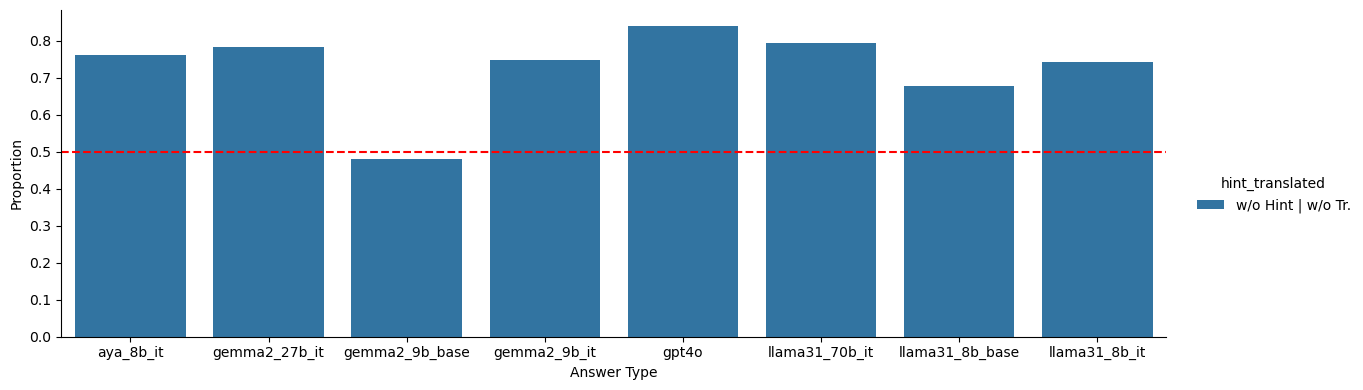

In [67]:
import seaborn as sns

import matplotlib.pyplot as plt

# Filter the dataframe to exclude 'none' ans_type
string_form = lambda x: ("w/" if x["hint"] else "w/o") + " Hint | " + ("w/" if x["translated"] else "w/o") + " Tr."

out_df["hint_translated"] = out_df.apply(string_form, axis=1)
out_df = out_df.query("hint_translated != 'xw/o Hint | w/o Tr.'")

group_df = out_df.groupby(['model', 'hint_translated', 'subtask','country'])["ans_type"].value_counts(normalize=True).unstack().fillna(0).reset_index()
group_df = group_df.groupby(['model', 'hint_translated'])["local"].mean().reset_index()


# Plot the data
g = sns.catplot(
    data=group_df, 
    kind="bar",
    order=out_df["model"].unique().sort(),
    x="model", 
    y="local", 
    hue="hint_translated", 
    height=4, 
    aspect=3
)
for ax in g.axes.flat:
    ax.axhline(0.5, ls='--', color='red')
g.set_axis_labels("Answer Type", "Proportion")
g.tight_layout()
plt.show()



In [12]:
gpt4o_out_df.groupby(["hint","translated"]).to_csv("gpt4o_none.csv", index=False)

In [26]:
out_df.query("model=='llama3_8b_base'").groupby(["hint","translated"])["ans_type"].value_counts(normalize=True)

hint   translated  ans_type
False  False       west        0.627550
                   local       0.372450
       True        west        0.510048
                   local       0.489952
True   False       local       0.919466
                   west        0.080534
       True        local       0.820371
                   west        0.179629
Name: proportion, dtype: float64

In [9]:
group_df

,model,hint_translated,local
0,aya_8b_it,Hint: False | Translated: True,0.508787
1,aya_8b_it,Hint: True | Translated: False,0.919678
2,aya_8b_it,Hint: True | Translated: True,0.735499
3,gemma2_9b_it,Hint: False | Translated: True,0.560337
4,gemma2_9b_it,Hint: True | Translated: False,0.895338
5,gemma2_9b_it,Hint: True | Translated: True,0.855548
6,gpt4o,Hint: False | Translated: True,0.528897
7,gpt4o,Hint: True | Translated: False,0.943128
8,gpt4o,Hint: True | Translated: True,0.920464
9,llama3_8b_it,Hint: False | Translated: True,0.478434


## Suffix Analysis

In [53]:
words = {
    "France" :["Baguette", "Paris", "Euro", "Guillotine"],       # France
    "Turkey": ["Baklava", "Istanbul", "Lira", "Nazar"],         # Turkey
    "United States": ["Burger", "New York", "Dollar", "Cowboy Hat"],   # USA
    "Bangladesh": ["Biriyani", "Dhaka", "Taka", "Rickshaw"],        # Bangladesh
    "Russia": ["Borscht", "Moscow", "Ruble", "Matryoshka"]      # Russia
}

translated_words = {
    "France": ["Baguette", "Paris", "Euro", "Guillotine"],  # France (French)
    "Turkey": ["Baklava", "İstanbul", "Lira", "Nazar"],  # Turkey (Turkish)
    "United States": ["Burger", "New York", "Dollar", "Cowboy hat"],  # USA (English)
    "Bangladesh": ["বিরিয়ানি", "ঢাকা", "টাকা", "রিকশা"],  # Bangladesh (Bengali)
    "Russia": ["Борщ", "Москва", "Рубль", "Матрёшка"]  # Russia (Russian)
}

In [58]:
subset_df = pd.read_csv("data/mclbench_subset_v1.csv")

subset_df = subset_df.query("hint==False").copy()

new_rows = []

for i, row in subset_df.iterrows():
    if row["lang"] != "English":
        suffix_list = translated_words
    else:
        suffix_list = words
    for j, word in enumerate(suffix_list[row["country"]]):
        new_row = row.copy()
        new_row["question"] = word +" "+new_row["question"]
        new_row["suffix"] = word
        new_rows.append(new_row)

In [59]:
pd.DataFrame(new_rows).to_csv("data/suffix_dataset.csv", index=False)

## Calculate Steering Vecs

In [5]:
country_to_suffix = {"Turkey": "tr", 
                     "France": "fr", 
                     "Russia": "ru", 
                     "Bangladesh": "bn", 
                     "United States": "us"}

In [46]:
def fix_str_ans(row):
    row["ans_local"] = row["options"][int(row["ans_local_idx"]) -1]
    row["ans_west"] = row["options"][int(row["ans_west_idx"]) -1]
    return row

In [ ]:
steering_df = pd.read_csv("model_gen/gemma2_9b_it_guess_suffix.csv")
steering_df["options"] = steering_df["options"].apply(eval_or_skip)
steering_df = steering_df.apply(fix_str_ans, axis=1)
steering_df = steering_df.apply(lambda x: get_answer_type_final(x, check_for="string"), axis=1)
steering_df.to_csv("model_gen/gemma2_9b_it_guess_suffix_fixed.csv")

NameError: name 'fix_str_ans' is not defined

In [15]:
from tools.nnsight_utils import collect_residuals, visualize_top_tokens

steering_df = pd.read_csv("model_gen/gemma2_9b_it_guess_suffix_fixed.csv")

steering_df["translated"] = steering_df.apply(lambda x: True if x["country"] == "United States" else x["lang"]!="English", axis=1)

countries = ["Turkey", "France", "Russia", "Bangladesh", "United States"]
#countries = ["United States"]
for country in countries:
    print(country)
    for subtask in ["names", "cities", "culturedistil", "culturebench"]:
        print(subtask)
        pos_examples = steering_df.query("country == @country and subtask == @subtask and translated==True and hint==True and ans_type == 'local'")
        neg_examples = steering_df.query("country == @country and subtask == @subtask and translated==True and hint==False and ans_type == 'west'")

        common_question_ids = set(pos_examples["question_id"].unique()) & set(neg_examples["question_id"].unique())

        if len(common_question_ids) == 0:
            question_ids = set(pos_examples["question_id"].unique()) | set(neg_examples["question_id"].unique())

        pos_examples = pos_examples.query("question_id in @common_question_ids").sort_values("question_id").copy()
        neg_examples = neg_examples.query("question_id in @common_question_ids").sort_values("question_id").copy()
        
        print(pos_examples.shape, neg_examples.shape)
        pos_examples.to_csv(f"residuals/gemma2_9b_it_v3_trans/{country_to_suffix[country]}_{subtask}_pos.csv", index=False)
        neg_examples.to_csv(f"residuals/gemma2_9b_it_v3_trans/{country_to_suffix[country]}_{subtask}_neg.csv", index=False)

        pos_res_list = []
        neg_res_list = []

        for pos, neg in tqdm(zip(pos_examples["input"], neg_examples["input"]), total=len(pos_examples)):
            pos_res = collect_residuals(nnmodel, pos, calculate_probs=False)["residuals"][:,0,-1,:]
            neg_res = collect_residuals(nnmodel, neg, calculate_probs=False)["residuals"][:,0,-1,:]
            pos_res_list.append(pos_res)
            neg_res_list.append(neg_res)
        pos_res = t.stack(pos_res_list)
        neg_res = t.stack(neg_res_list)

        t.save(pos_res, f"residuals/gemma2_9b_it_v3_trans/{country_to_suffix[country]}_{subtask}_pos.pt")
        t.save(neg_res, f"residuals/gemma2_9b_it_v3_trans/{country_to_suffix[country]}_{subtask}_neg.pt")


Turkey
names
(61, 21) (61, 21)


  3%|▎         | 2/61 [00:00<00:11,  5.25it/s]

100%|██████████| 61/61 [00:11<00:00,  5.43it/s]


cities
(102, 21) (102, 21)


100%|██████████| 102/102 [00:18<00:00,  5.40it/s]


culturedistil
(55, 21) (55, 21)


100%|██████████| 55/55 [00:10<00:00,  5.45it/s]


culturebench
(14, 21) (14, 21)


100%|██████████| 14/14 [00:02<00:00,  5.37it/s]


France
names
(53, 21) (53, 21)


100%|██████████| 53/53 [00:09<00:00,  5.54it/s]


cities
(68, 21) (68, 21)


100%|██████████| 68/68 [00:12<00:00,  5.28it/s]


culturedistil
(42, 21) (42, 21)


100%|██████████| 42/42 [00:07<00:00,  5.43it/s]


culturebench
(2, 21) (2, 21)


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


Russia
names
(54, 21) (54, 21)


100%|██████████| 54/54 [00:09<00:00,  5.58it/s]


cities
(153, 21) (153, 21)


100%|██████████| 153/153 [00:27<00:00,  5.62it/s]


culturedistil
(50, 21) (50, 21)


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]


culturebench
(10, 21) (10, 21)


100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Bangladesh
names
(25, 21) (25, 21)


100%|██████████| 25/25 [00:06<00:00,  4.03it/s]


cities
(52, 21) (52, 21)


100%|██████████| 52/52 [00:12<00:00,  4.02it/s]


culturedistil
(35, 21) (35, 21)


100%|██████████| 35/35 [00:08<00:00,  3.94it/s]


culturebench
(5, 21) (5, 21)


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


United States
names
(61, 21) (61, 21)


100%|██████████| 61/61 [00:10<00:00,  5.65it/s]


cities
(80, 21) (80, 21)


100%|██████████| 80/80 [00:13<00:00,  5.85it/s]


culturedistil
(60, 21) (60, 21)


100%|██████████| 60/60 [00:10<00:00,  5.58it/s]


culturebench
(5, 21) (5, 21)


100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


## Patchscope

In [16]:
all_data = pd.read_csv("model_gen/gemma2_9b_it_greedy_mult_choice.csv")

all_data["subtask"] = all_data["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))

In [17]:
import re

def swap_options(prompt):
    # Match the options in the form of "1. Option1\n2. Option2"
    pattern = r"\n1\.\s*(.*?)\n2\.\s*(.*?)(?=\n|$)"

    def swap_match(match):
        option1, option2 = match.groups()
        return f"\n1. {option2}\n2. {option1}"

    # Substitute the matched pattern with swapped options
    swapped_prompt = re.sub(pattern, swap_match, prompt)

    return swapped_prompt

def change_numbers(prompt):
    # Match the options in the form of "1. Option1\n2. Option2"
    pattern = r"\n1\.\s*(.*?)\n2\.\s*(.*?)(?=\n|$)"

    def change_match(match):
        option1, option2 = match.groups()
        return f"\nA. {option1}\nB. {option2}"

    # Substitute the matched pattern with swapped options
    swapped_prompt = re.sub(pattern, change_match, prompt)

    return swapped_prompt

In [190]:
test_data = all_data.query("lang=='English' and hint==False and ans_type!='local'").copy()

test_data_list = []

for c in ["Turkey", "France", "Russia", "Bangladesh"]:
    for task in ["names", "cities", "culturedistil"]:
        task_data = test_data.query(f"subtask=='{task}' and country=='{c}'")
        task_data = task_data.sample(n=min(task_data.shape[0],50), random_state=42)
        test_data_list.append(task_data)

test_data = pd.concat(test_data_list).sort_values("question_id")

question_ids = set(test_data["question_id"].unique())
source_data = all_data.query("question_id in @question_ids and hint==False and lang!='English'").copy().sort_values("question_id")
test_data.shape

(600, 17)

In [91]:
import torch as t

patching_res_map = {}

for task in ["names", "cities", "culturedistil"]:
    for s in ["tr", "fr", "ru", "bn"]:
        patching_res_map[(task,s)] = t.load(f"residuals/gemma2_9b_it/{s}_{task}_pos.pt", weights_only=False).mean(dim=0).unsqueeze(1)



In [127]:
source_entries = source_data.query("country=='Turkey'").to_dict(orient="records")
test_entries = test_data.query("country=='Turkey'").to_dict(orient="records")

index = 4

source_prompt = swap_options(source_entries[index]["input"])
target_prompt = test_entries[index]["input"]


In [128]:
print(source_prompt)
print(target_prompt)


<bos><start_of_turn>user
Soru:Aşağıdaki çoktan seçmeli soruya cevap vermek için, yalnızca 1,2,3,4 arasından bir seçenek seçmelisiniz. Talimat: 1,2,3,4 arasından bir seçenek seçmelisiniz. Başka bir şey çıkarmayın.
Bir çatı kafede müşteriler hangi içeceğin tadını çıkarır?
Seçenekler:
1. Rakı<end_of_turn>
2. Beyaz şarap
<start_of_turn>model

<bos><start_of_turn>user
Question:To answer the following multiple-choice question, you should choose one option only among 1,2,3,4. Instruction: You must select one option among 1,2,3,4. Do not output any other things.
At a rooftop café, which beverage do patrons savor?
Options:
1. White wine
2. Rakı<end_of_turn>
<start_of_turn>model



In [129]:
source_res = collect_residuals(nnmodel, source_prompt, calculate_probs=False)["residuals"][:,0,-1,:]
out = patch_scope_gen(nnmodel, tokenizer, source_res.unsqueeze(1).unsqueeze(1),
                        target_prompt=target_prompt, target_token_idx=-1, n_new_tokens=1)

In [101]:
print(test_entries[0]["input"])

<bos><start_of_turn>user
Question:To answer the following multiple-choice question, you should choose one option only among 1,2,3,4. Instruction: You must select one option among 1,2,3,4. Do not output any other things.
Around here, what do people usually drink to accompany their meals?
Options:
1. Kvass
2. Iced Tea<end_of_turn>
<start_of_turn>model



In [191]:
from tqdm import tqdm

outputs = []
mean_patch = False


countries = ["Turkey", "France", "Russia", "Bangladesh"]

batch_size = 32
for country in countries:
    print(country)
    

    test_entries = test_data.query("country==@country").to_dict(orient="records")
    source_entries = source_data.query("country==@country").to_dict(orient="records")


    batch_entries = [test_entries[k:k+batch_size] for k in range(0, len(test_entries), batch_size)]
    batch_inputs = [[entry["input"] for entry in batch] for batch in batch_entries]

    batch_residuals = []
    if mean_patch:
        s = country_to_suffix[country]
        patching_res = patching_res_map[("cities",s)].mean(dim=0).unsqueeze(0)
    else:
        for k in range(0, len(source_entries), batch_size):
            source_batch = source_entries[k:k+batch_size]
            res_batch = []
            with t.no_grad():
                for i,entry in enumerate(source_batch):
                    imp = change_numbers(entry["input"])
                    res_batch.append(collect_residuals(nnmodel, imp, calculate_probs=False)["residuals"][:,0,-1,:])
                res_batch = t.stack(res_batch, dim=1).unsqueeze(2)
                batch_residuals.append(res_batch)

    for i,batch_imp in tqdm(enumerate(batch_inputs), total=len(batch_inputs)):
        with t.no_grad():
            if mean_patch:
                out = patch_scope_gen(nnmodel, tokenizer, patching_res.unsqueeze(1).repeat(1, len(batch_imp), 1, 1), 
                                      target_prompt=batch_imp, target_token_idx=-1, n_new_tokens=1)
            else:
                out = patch_scope_gen(nnmodel, tokenizer, batch_residuals[i], 
                                      target_prompt=batch_imp, target_token_idx=-1, n_new_tokens=1)

            for j,layer in enumerate(out[0]):
                texts = out[0][layer]
                probs = out[1]
                epsilon = 1e-6
                probs[probs < epsilon] = 0
                #probs = probs.to_sparse()
                for k, text in enumerate(texts):
                    out_dict = {"patch_out": text, "patch_prob": probs[j,:,k,:].to_sparse(), "layer": layer}
                    out_dict.update(batch_entries[i][k])
                    outputs.append(out_dict)

Turkey


100%|██████████| 5/5 [01:19<00:00, 15.97s/it]


France


100%|██████████| 5/5 [01:19<00:00, 15.94s/it]


Russia


100%|██████████| 5/5 [01:25<00:00, 17.14s/it]


Bangladesh


100%|██████████| 5/5 [01:25<00:00, 17.09s/it]


In [192]:
pd.to_pickle(outputs, "patchscope/all_imp_english_pair_patching_letters.pkl")

In [141]:
outputs = pd.read_pickle("patchscope/all_exp_english_pair_patching_numbers.pkl")

In [140]:
outputs = pd.read_pickle("patchscope/all_imp_english_pair_patching_letters.pkl")

In [146]:
def get_probs(data_row, tokenizer, token_index):
    ans_west = data_row["ans_west"]
    ans_local = data_row["ans_local"]
    
    ind_west = tokenizer.encode(ans_west, add_special_tokens=False)[0]
    ind_local = tokenizer.encode(ans_local, add_special_tokens=False)[0]
    ind_source_1 = tokenizer.encode("3", add_special_tokens=False)[0]
    ind_source_2 = tokenizer.encode("4", add_special_tokens=False)[0]


    
    data_row["prob_west"] = data_row["patch_prob"].to_dense()[token_index, ind_west].float().numpy()
    data_row["prob_local"] = data_row["patch_prob"].to_dense()[token_index, ind_local].float().numpy()
    data_row["prob_source"] = max(data_row["patch_prob"].to_dense()[token_index, ind_source_1].float().numpy(),
                                    data_row["patch_prob"].to_dense()[token_index, ind_source_2].float().numpy())
    return data_row

In [147]:
outputs_df = pd.DataFrame(outputs)
opt_to_str = lambda x: str(int(x))
outputs_df["ans_west"] = outputs_df["ans_west_idx"].apply(opt_to_str)
outputs_df["ans_local"] = outputs_df["ans_local_idx"].apply(opt_to_str)

outputs_df.dropna(subset=["ans_west", "ans_local"], inplace=True)

In [148]:
outputs_df = outputs_df.apply(lambda x: get_probs(x, tokenizer, token_index=-1), axis=1)
outputs_df.dropna(subset=["prob_west", "prob_local"], inplace=True)
outputs_df.drop(columns=["patch_prob"], inplace=True)


(600, 42)


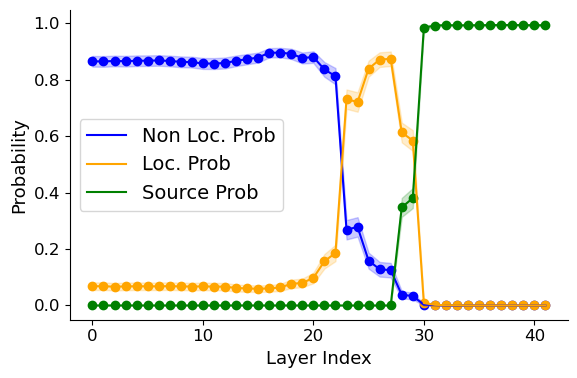

In [149]:
from tools.patchscope import plot_avg_probs_ax
fig, ax = plot_avg_probs_ax(outputs_df.query("country!='xRussia'"), include_source=True)
fig.savefig("exp_patchscope.pdf", dpi=300, bbox_inches='tight')


In [ ]:
# translated hint
# english non-hint

(600, 42)


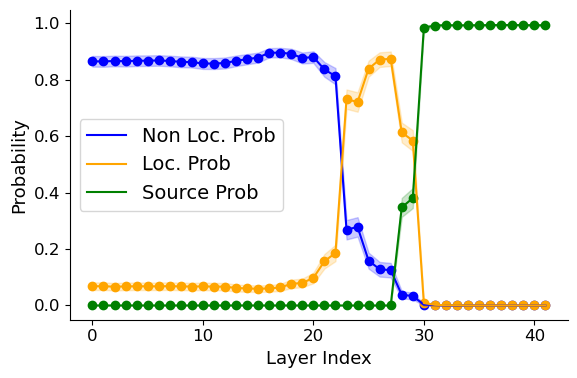

In [27]:
from tools.patchscope import plot_avg_probs_ax
plot_avg_probs_ax(outputs_df.query("country!='xRussia'"), include_source=True)

## Projections on Steering Vec

In [6]:

steering_vec_map = {}
for prefix in ["tr", "fr", "ru", "bn"]:
    res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_pos.pt", weights_only=True)
    res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_neg.pt", weights_only=True)

    steering_vec = (res_tr - res_en).mean(dim=0)
    steering_vec = steering_vec.unsqueeze(1)
    steering_vec_map[prefix] = steering_vec

FileNotFoundError: [Errno 2] No such file or directory: 'residuals/gemma2_9b_it/tr_pos.pt'

In [25]:
from tools.evaluation import get_answer_type_final

query = "country=='Turkey' and hint=='none' and lang!='English'"

samples = final_df.query(query).copy()

samples["ans_type"] = samples["ans_type_w_pref"]
samples["input_en"] = samples["question_id"].apply(lambda qid: final_df.query("question_id == @qid and lang == 'English'")["input"].values[0])
samples["input_en"] = samples["input_en"] + prompt_suffix["English"]

vector = steering_vec_map["tr"]

In [26]:
layers = [21,22,23,24,25,26,27]
rows = []
for idx, samp in samples.iterrows():
    source_prompt = samp["input"] + prompt_suffix[samp["lang"]]
    model_out = collect_residuals(nnmodel, source_prompt, calculate_probs=False)
    #model_out_en = collect_residuals(nnmodel, samp["input_en"], calculate_probs=False)
    residuals = model_out["residuals"][:,0,-1,:]# - model_out_en["residuals"][:,0,-1,:]
    for layer in layers:
        proj = t.inner(residuals[layer,:],vector[layer,0,:])
        proj = (proj/vector[layer,0,:].norm().item()).cpu().float().numpy()
        samp[f"layer_{layer}_proj"] = proj
    rows.append(samp)

projected_df = pd.DataFrame(rows)

In [23]:
# Explicit vector projection on translated prompts
projected_df.groupby("ans_type")[[f"layer_{layer}_proj" for layer in layers]].mean()

,layer_21_proj,layer_22_proj,layer_23_proj,layer_24_proj,layer_25_proj,layer_26_proj,layer_27_proj
ans_type,,,,,,,
local,-11.492989,-17.176403,-10.544841,-48.457953,-47.65527,-54.695468,-101.445183
none,4.307617,1.490234,4.619141,-25.71875,-11.600586,-5.929688,-45.1875
west,-8.694786,-13.542839,-9.705671,-45.867391,-45.361583,-52.467527,-97.830978


In [27]:
# Implicit vector projection on translated prompts
projected_df.groupby("ans_type")[[f"layer_{layer}_proj" for layer in layers]].mean()

,layer_21_proj,layer_22_proj,layer_23_proj,layer_24_proj,layer_25_proj,layer_26_proj,layer_27_proj
ans_type,,,,,,,
local,5.824968,-2.815858,13.031561,-32.440199,-19.422407,-30.553338,-90.283223
none,8.851562,-1.930664,14.984375,-27.5625,-2.699219,-2.9375,-58.625
west,7.344497,-0.854755,14.089912,-30.815217,-18.299881,-30.30377,-89.483696


## Evaluate Steering

In [83]:
steering_vec_map = {}
steering_vecs = []
tasks = ["names", "cities", "culturedistil", "culturebench"]
#tasks = ["names"]

avg_type = "micro"

for prefix in ["tr", "fr", "ru", "bn", "us"]:
    print(prefix)
    steering_vecs = []
    for task in tasks:
        res_tr = t.load(f"residuals/gemma2_9b_it_v3_trans/{prefix}_{task}_pos.pt", weights_only=True)
        res_en = t.load(f"residuals/gemma2_9b_it_v3_trans/{prefix}_{task}_neg.pt", weights_only=True)

        steering_vec = (res_tr - res_en)

        if avg_type == "macro":
            steering_vecs.append(steering_vec.mean(dim=0))
        else:
            steering_vecs.append(steering_vec)
    
    print(len(steering_vecs))
    steering_vec = t.cat(steering_vecs, dim=0)
    print(steering_vec.shape)
    steering_vec = steering_vec.mean(dim=0)
    steering_vec_map[("micro",prefix)] = steering_vec.unsqueeze(1)

#steering_vec = steering_vec_map["tr"]

tr
4
torch.Size([232, 42, 3584])
fr
4
torch.Size([165, 42, 3584])
ru
4
torch.Size([267, 42, 3584])
bn
4
torch.Size([117, 42, 3584])
us
4
torch.Size([206, 42, 3584])


In [15]:
steering_vec_map = {}
steering_vecs = []
tasks = ["names", "cities", "culturedistil", "culturebench"]
#tasks = ["names"]

avg_type = "micro"

for prefix in ["tr", "fr", "ru", "bn", "us"]:
    print(prefix)
    #steering_vecs = []
    for task in tasks:
        res_tr = t.load(f"residuals/gemma2_9b_it_v3_trans/{prefix}_{task}_pos.pt", weights_only=True)
        res_en = t.load(f"residuals/gemma2_9b_it_v3_trans/{prefix}_{task}_neg.pt", weights_only=True)

        steering_vec = (res_tr - res_en)

        if avg_type == "macro":
            steering_vecs.append(steering_vec.mean(dim=0))
        else:
            steering_vecs.append(steering_vec)
    
    print(len(steering_vecs))

steering_vec = t.cat(steering_vecs, dim=0)
print(steering_vec.shape)

steering_vec = steering_vec.mean(dim=0)
for prefix in ["tr", "fr", "ru", "bn", "us"]:
    steering_vec_map[("micro",prefix)] = steering_vec.unsqueeze(1)

tr
4
fr
8
ru
12
bn
16
us
20
torch.Size([987, 42, 3584])


In [43]:
steering_vec_map = {}
steering_vecs = []
tasks = ["names", "cities", "culturedistil", "culturebench"]
#tasks = ["names"]

for prefix in ["tr", "fr", "ru", "bn", "us"]:
    print(prefix)
    for task in tasks:
        res_tr = t.load(f"residuals/gemma2_9b_it_v3/{prefix}_{task}_pos.pt", weights_only=True)
        res_en = t.load(f"residuals/gemma2_9b_it_v3/{prefix}_{task}_neg.pt", weights_only=True)

        steering_vec = (res_tr - res_en).mean(dim=0)

        print(steering_vec.shape)
        steering_vec_map[(task,prefix)] = steering_vec.unsqueeze(1)

tr
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
fr
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
ru
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
bn
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
us
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])


### Open-ended

In [92]:
prompt = """
<bos><start_of_turn>user
Can you describe me a traditional dance?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

In [103]:
prompt = """
<bos><start_of_turn>user
Can you give me a traditional recipe?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

In [111]:
open_ended_examples = pd.read_json(f"data/open_ended_generation/{pref}_False.json")


NameError: name 'pref' is not defined

In [44]:
from tools.prepare_input import messages_to_str

pref = "tr"
open_ended_examples = pd.read_json(f"data/open_ended_generation/{pref}_False.json")

en_prompts = open_ended_examples["story"].tolist()
tr_prompts = open_ended_examples["translation"].tolist()


en_inputs = [messages_to_str([{"role": "user", "content": prompt}], tokenizer, instruction_model=True) for prompt in en_prompts]
tr_inputs = [messages_to_str([{"role": "user", "content": prompt}], tokenizer, instruction_model=True)  for prompt in tr_prompts]

In [68]:
prompt = en_inputs[0]

print(prompt)

<bos><start_of_turn>user
Write me a recipe for a local dish.<end_of_turn>
<start_of_turn>model



In [73]:
alpha = 2

steering_vec = steering_vec_map[("micro","bn")]

out = contrastive_act_gen_opt(nnmodel, tokenizer, alpha * steering_vec, prompt=prompt, layer=[21,22,23,24,25], n_new_tokens=50, use_sampling=True)


In [74]:
out[0]

{21: ['##  Chicken and Coconut Curry (Kerala, India)\n\nThis recipe is for a delicious and authentic Kerala-style chicken curry, a staple in South Indian cuisine. \n\n**Yields:** 4-6 servings\n**Prep time:** '],
 22: ['##  Spicy Shrimp and Coconut Curry (Kerala, India)\n\nThis recipe is for a spicy shrimp curry, a staple dish in Kerala, India. \n\n**Yields:** 4 servings\n**Prep time:** 20 minutes\n**'],
 23: ['##  Spicy Shrimp & Coconut Curry (Kerala, India)\n\nThis recipe is for a delicious and authentic Kerala-style shrimp curry, bursting with flavor and spice. \n\n**Ingredients:**\n\n* **For the Curry:**\n    * 1'],
 24: ["##  **Chiles en Nogada:** A Traditional Mexican Dish\n\n**Chiles en Nogada** is a celebrated dish in Mexico, often served during the country's Independence Day celebrations. It features roasted poblano peppers filled with a savory"],
 25: ["##  Mutton Rogan Josh (Kashmiri Rogan Josh)\n\n**Aromatic, flavorful, and rich, Rogan Josh is a Kashmiri delicacy made with m

In [ ]:
from tools.contrastiveact import contrastive_act_gen_opt
from tqdm import trange

alpha=2

outs_dict = {}
for pref in ["tr", "fr", "ru", "bn", "us"]:
    steering_vec = steering_vec_map[("micro",pref)]
    outs = []
    for i in trange(2):
        out = contrastive_act_gen_opt(nnmodel, tokenizer, alpha * steering_vec, prompt=en_inputs[0], layer=[25], n_new_tokens=50, use_sampling=False)
        outs.extend(out[0][25])
    outs_dict[pref] = outs


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:08<00:00,  4.40s/it]


In [89]:
outs_dict

{'tr': ["##  Karnataka's Spicy Bisi Bele Bath \n\nThis is a beloved South Indian dish hailing from Karnataka, known for its rich flavors and spicy kick. \n\n**Ingredients:**\n\n* **For the Bath:**\n    * ",
  '##  Spicy Shrimp and Grits \n\nThis recipe is inspired by the Lowcountry cuisine of South Carolina, a region known for its delicious and hearty dishes featuring shrimp, grits, and plenty of spice. \n\n**Ingredients:**\n\n* **For'],
 'fr': ["##  Moules Marinières (Mussels Marinieres) - A Classic French Dish from Normandy\n\nThis recipe is for Moules Marinières, a beloved dish from Normandy, France. It's a simple yet flavorful preparation of mussels cooked",
  '##  Moules Marinières (Mussels in White Wine Sauce) - A Taste of Normandy, France\n\n**This recipe is for a classic French dish hailing from Normandy, known for its fresh mussels and rich white wine sauce.**\n\n**'],
 'ru': ['##  Churrasco de Cordeiro Assado com Arroz de Caruru (Brazilian Roasted Lamb with Caruru Rice)\n\nTh

In [78]:
pd.to_pickle(outs_dict, "open_ended/micro25_2_dish_out.pkl")

In [ ]:
out

In [160]:
out

({22: ["Please tell me what kind of local dish you'd like! \n\nHere are some ideas to get you started:\n\n* **A dish that's traditionally made with a specific ingredient:**  Think of a dish that's unique to a region or is made with a specific ingredient that's hard to find elsewhere. \n* **A dish that's traditionally made with a specific type of cuisine:**  Think of a dish that's traditionally made with a specific type of cuisine:  \n* **A dish that's traditionally made with a specific ingredient:**  Think of a dish that's traditionally made with a specific ingredient that's hard to find elsewhere.  \n* **A dish that's traditionally made with a specific type of cuisine:**  Think of a dish that's traditionally made with a specific type of cuisine: \n\nSome examples of dishes that are traditionally made with a specific ingredient or cuisine:\n\n* **Mofeta (Moroccan) and  \n* **Mofeta (Moroccan) and  \n* **Mofeta (Moroccan) and  \n* **Mofeta (Moroccan) and  \n* **Mofeta (Moroccan) and  \n

In [158]:
out

({22: ['Please tell me what region or country you\'d like a local dish from! \n\nFor example, you could say:\n\n* "A recipe for a local dish from Tuscany"\n* "A recipe for a local dish from Vietnam"\n* "A recipe for a local dish from the Philippines"\n\n\nI can give you a traditional recipe or one with a modern twist.  Let me know! \n<end_of_turn><eos><eos><eos><eos><end_of_turn><eos><eos><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos>\n<eos><end_of_turn><eos><eos><end_of_turn><eos>\n<eos><end_of_turn><eos>\n<eos><end_of_turn><eos>\n<eos><end_of_turn><eos>\n<eos><end_of_turn><eos>\n<end_of_turn><eos>\n<eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn>\n<end_of_turn><eos>\n<end_of_turn>\n<eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn>\n<end_of_turn><eos>\n<end_of_turn>\n<end_of_turn>

In [ ]:
# tr recipe, alpha=4.0, culturedistil vec, l 25
# fr recipe, alpha=5.0, culturedistil vec, l 25,26,27

In [109]:
out[0]

{22: ["##  Traditional French Onion Soup (Soupe à l'oignon gratinée)\n\nThis recipe is a classic example of French cuisine, known for"]}

### Steering Test Data

In [27]:
test_data = pd.read_csv("model_gen/gemma2_9b_it_greedy_mult_choice.csv")

test_data["options"] = test_data["options"].apply(eval_or_skip)
test_data.dropna(subset=["options"], inplace=True)

src_map = {
"synth_names":"names",
"synth_cities":"cities",
"culturebench":"culturebench",
}

test_data["subtask"] = test_data["source_id"].apply(lambda x: src_map.get(x, "culturedistil"))

names_data = test_data.query("subtask=='names' and lang=='English'").copy()
cities_data = test_data.query("subtask=='cities' and lang=='English'").copy()
rest_data = test_data.query("subtask!='names' and subtask!='cities'").copy()


dfs = [rest_data]

question_ids = list(rest_data["question_id"].unique())

for country in ["Turkey", "France", "Russia", "Bangladesh"]:
    for df, samp_size in [(names_data,1), (cities_data,5)]:
        country_df = df.query(f"country=='{country}'")

        unique_ans_west = country_df["ans_west"].unique()
        unique_ans_local = country_df["ans_local"].unique()

        w_df = pd.concat([country_df[country_df["ans_west"] == ans].sample(n=samp_size, random_state=42) for ans in unique_ans_west])
        rm_ans = set(unique_ans_local) - set(w_df["ans_local"])
        l_df = pd.concat([country_df[country_df["ans_local"] == ans].sample(n=samp_size, random_state=42) for ans in rm_ans])
        question_ids.extend(pd.concat([w_df,l_df])["question_id"].unique())

question_ids = set(question_ids)


steering_test_data = test_data.query("question_id in @question_ids").copy()

In [62]:
steering_test_data.to_csv("data/steering_test_data.csv", index=False)

### Steering Eval

In [33]:
test_data = pd.read_csv("model_gen/all_models_eval_subset.csv")
test_data = test_data.query("model=='gemma2_9b_it'").copy()

test_data["options"] = test_data["options"].apply(eval_or_skip)
test_data.dropna(subset=["options"], inplace=True)

src_map = {
"synth_names":"names",
"synth_cities":"cities",
"culturebench":"culturebench",
}

test_data["subtask"] = test_data["source_id"].apply(lambda x: src_map.get(x, "culturedistil"))
test_data = test_data.query("hint==False").copy()

test_data.shape

(5987, 19)

In [34]:
test_data["subtask"].unique()

array(['names', 'cities', 'culturedistil', 'culturebench'], dtype=object)

In [19]:
from tools.contrastiveact import contrastive_act_gen_opt
from tqdm import tqdm


#layers = [24, 25, 26, 27]
#layers = [15,16,17,18,19,20,21,22,23,24,25] + [26,27,28,29,30]
layers = [21,22,23,24,25,26,27]
layers = [15,16,17,18,19,20,28,29,30]
#layers = [15,16,17,18,19,20,28,29,30]
#layers = [21]


#alphas = [1,2,3]
alphas = [-2,-1,1,2]

#alphas = [0]
outputs = []

batch_size = 64


for country in country_to_suffix:
    for task in ["names", "cities", "culturedistil", "culturebench"]:
        print(country, task)
        s = country_to_suffix[country]
        steering_vec = steering_vec_map[("micro",s)]
        test_entries = test_data.query("country==@country and subtask==@task").to_dict(orient="records")

        batch_entries = [test_entries[k:k+batch_size] for k in range(0, len(test_entries), batch_size)]
        batch_inputs = [[entry["input"] for entry in batch] for batch in batch_entries]

        for i,batch_imp in tqdm(enumerate(batch_inputs), total=len(batch_inputs)):
            for alpha in alphas:
                with t.no_grad():
                    out = contrastive_act_gen_opt(nnmodel, tokenizer, alpha * steering_vec, prompt=batch_imp, layer=layers, n_new_tokens=1)
                    for j,layer in enumerate(out[0]):
                        texts = out[0][layer]
                        probs = out[1]
                        epsilon = 1e-6
                        probs[probs < epsilon] = 0

                        for k, text in enumerate(texts):
                            out_dict = {"alpha": alpha, "steer_out": text, "steer_prob": probs[j,k,:,:].to_sparse(), "layer": layer}
                            out_dict.update(batch_entries[i][k])
                            outputs.append(out_dict)
                            pass

Turkey names


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [03:09<00:00, 27.02s/it]


Turkey cities


100%|██████████| 6/6 [02:40<00:00, 26.75s/it]


Turkey culturedistil


100%|██████████| 7/7 [03:43<00:00, 31.97s/it]


Turkey culturebench


100%|██████████| 4/4 [02:32<00:00, 38.04s/it]


France names


100%|██████████| 7/7 [02:52<00:00, 24.58s/it]


France cities


100%|██████████| 6/6 [02:23<00:00, 23.92s/it]


France culturedistil


100%|██████████| 5/5 [02:20<00:00, 28.07s/it]


France culturebench


100%|██████████| 2/2 [00:43<00:00, 21.56s/it]


Russia names


100%|██████████| 5/5 [01:54<00:00, 22.82s/it]


Russia cities


100%|██████████| 6/6 [02:25<00:00, 24.25s/it]


Russia culturedistil


100%|██████████| 5/5 [02:30<00:00, 30.12s/it]


Russia culturebench


100%|██████████| 3/3 [01:35<00:00, 31.85s/it]


Bangladesh names


100%|██████████| 7/7 [05:18<00:00, 45.52s/it]


Bangladesh cities


100%|██████████| 5/5 [03:19<00:00, 39.89s/it]


Bangladesh culturedistil


100%|██████████| 5/5 [04:55<00:00, 59.08s/it]


Bangladesh culturebench


100%|██████████| 3/3 [02:40<00:00, 53.60s/it]


United States names


100%|██████████| 7/7 [02:35<00:00, 22.20s/it]


United States cities


100%|██████████| 6/6 [02:25<00:00, 24.20s/it]


United States culturedistil


100%|██████████| 6/6 [02:38<00:00, 26.38s/it]


United States culturebench


100%|██████████| 1/1 [00:34<00:00, 34.39s/it]


In [11]:
len(outputs)

215532

In [20]:
pd.to_pickle(outputs, "caa/gemma2_9b_it_v3/subset_allcountry_transmicro_otherlayers.pkl")
#pd.to_pickle(outputs, "caa/testdata_allcountry_nosteer.pkl")

In [5]:
outputs = pd.read_pickle("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_upper.pkl")
#outputs = pd.read_pickle("caa/gemma2_9b_it_no_steer_batch_mult_4.pkl")

KeyboardInterrupt: 

In [21]:
from tqdm import tqdm


same_token_questions = set()
new_rows = []

setting = "mult_choice"

for out in tqdm(outputs):

    if setting == "mult_choice":
        out["ans_west"] = str(int(out["ans_west_idx"]))
        out["ans_local"] = str(int(out["ans_local_idx"]))

    west_ind = tokenizer.encode(out["ans_west"], add_special_tokens=False)[0]
    out["prob_west"] = out["steer_prob"][0,west_ind].item()



    local_ind = tokenizer.encode(out["ans_local"], add_special_tokens=False)[0]
    out["prob_local"] = out["steer_prob"][0,local_ind].item()



    if out["ans_west"] in str(out["steer_out"]):
        out["ans_type"] = "west"
    elif out["ans_local"] in str(out["steer_out"]):
        out["ans_type"] = "local"
    else:
        out["ans_type"] = "none"

    #next_token = out["steer_prob"].to_dense()[0,:].argmax().item()
    '''
    out["ans_type"] = "none"

    if next_token == west_ind:
        out["ans_type"] = "west"
    elif next_token == local_ind:
        out["ans_type"] = "local"
    else:
        out["ans_type"] = "none"

    '''
    new_rows.append(out)

100%|██████████| 215532/215532 [00:33<00:00, 6499.11it/s]


In [22]:
steer_df = pd.DataFrame(new_rows)
steer_df.to_csv("caa/gemma2_9b_it_v3/subset_allcountry_transmicro_otherlayers.csv", index=False)
#steer_df.to_csv("caa/testdata_allcountry_nosteer.csv", index=False)

In [74]:
steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis.csv")
steer_df = pd.concat([steer_df, 
                      pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_upper.csv"),
                      pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_highalpha.csv")])

/tmp/ipykernel_1391/2411795406.py:1: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis.csv")
/tmp/ipykernel_1391/2411795406.py:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_highalpha.csv")])


In [30]:
per_steer_df = pd.concat(
    [pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_posalpha.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_remainalpha.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_2627.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_alpha3.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_remaininglayer.csv")  
    ])

per_steer_df["vector"] = "pertask"


name_steer_df = pd.concat([pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis.csv"),
                      pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_upper.csv"),
                      pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_highalpha.csv"),
                      pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_alpha3.csv")])

name_steer_df["vector"] = "names"

steer_df = pd.concat([per_steer_df, name_steer_df])


/tmp/ipykernel_1212/3087529440.py:6: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_remaininglayer.csv")
/tmp/ipykernel_1212/3087529440.py:12: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  name_steer_df = pd.concat([pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis.csv"),
/tmp/ipykernel_1212/3087529440.py:14: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_highalpha.csv"),


In [53]:
en_steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enuniversal_mainlayers.csv")
en_steer_df["vector"] = "enuniversal"

trans_steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transuniversal_mainlayers.csv")
trans_steer_df["vector"] = "transuniversal"

steer_df = pd.concat([en_steer_df, trans_steer_df])


/tmp/ipykernel_1212/2502422536.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  en_steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enuniversal_mainlayers.csv")
/tmp/ipykernel_1212/2502422536.py:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transuniversal_mainlayers.csv")


In [54]:
en_steer_df = pd.concat([
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enmicro_mainlayers.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enmicro_otherlayers.csv"),
])
en_steer_df["vector"] = "enmicro"

trans_steer_df = pd.concat([
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transmicro_mainlayers.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transmicro_otherlayers.csv"),
])

trans_steer_df["vector"] = "transmicro"

steer_df = pd.concat([steer_df, en_steer_df, trans_steer_df])

/tmp/ipykernel_1212/4273588782.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enmicro_mainlayers.csv"),
/tmp/ipykernel_1212/4273588782.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enmicro_otherlayers.csv"),
/tmp/ipykernel_1212/4273588782.py:8: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transmicro_mainlayers.csv"),
/tmp/ipykernel_1212/4273588782.py:9: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transmicro_otherlayers.csv"),


In [55]:
def get_abs_type(out):
    if str(int(out["ans_west_idx"])) in str(out["steer_out"]):
        out["ans_type"] = "west"
    elif str(int(out["ans_local_idx"])) in str(out["steer_out"]):
        out["ans_type"] = "local"
    else:
        out["ans_type"] = "none"
    return out["ans_type"]

steer_df["ans_type"] = steer_df.apply(get_abs_type, axis=1)

In [56]:

steer_df["unique_id"] = steer_df["question_id"].astype(str) + steer_df["lang"] + steer_df["country"] + steer_df["hint"].astype(str)
unique_ids = set(steer_df["unique_id"].unique())

no_steer_res = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_no_steer.csv")
no_steer_res["unique_id"] = no_steer_res["question_id"].astype(str) + no_steer_res["lang"] + no_steer_res["country"] + no_steer_res["hint"].astype(str)

no_steer_res = no_steer_res.query("unique_id in @unique_ids").copy()

dfs = []
for l in steer_df["layer"].unique():
    n = no_steer_res.copy()
    n["vector"] = "none"
    n["layer"]=l
    dfs.append(n)
no_steer_res = pd.concat(dfs)


steer_df = [steer_df, no_steer_res]
steer_df = pd.concat(steer_df)

steer_df.drop(columns=["steer_prob"], inplace=True)

In [57]:
question_ids = set(steer_df["question_id"].unique())
hinted = pd.read_csv("model_gen/all_models_eval_subset.csv").query("model =='gemma2_9b_it' and hint==True and question_id in @question_ids").copy()

src_map = {
"synth_names":"names",
"synth_cities":"cities",
"culturebench":"culturebench",
}

hinted["subtask"] = hinted["source_id"].apply(lambda x: src_map.get(x, "culturedistil"))

hinted["local_ans"] = (hinted["ans_type"] == "local").astype(int)
hinted["west_ans"] = (hinted["ans_type"] == "west").astype(int)
hinted["no_ans"] = (hinted["ans_type"] == "none").astype(int)



In [58]:
steer_df["local_ans"] = (steer_df["ans_type"] == "local").astype(int)
steer_df["west_ans"] = (steer_df["ans_type"] == "west").astype(int)
steer_df["no_ans"] = (steer_df["ans_type"] == "none").astype(int)

steer_df = steer_df.merge(
    steer_df.query("alpha == 0")[["question_id", "country", "lang", "hint", "subtask", "layer", "local_ans", "west_ans", "no_ans"]].rename(columns={"local_ans": "local_ans_base", "west_ans": "west_ans_base", "no_ans": "no_ans_base"}),
    on=["question_id","lang", "subtask", "layer", "hint", "country"],
    how="inner"
)
steer_df["delta_local_ans"] = steer_df["local_ans"] - steer_df["local_ans_base"]
steer_df["delta_west_ans"] = steer_df["west_ans"] - steer_df["west_ans_base"]
steer_df["delta_no_ans"] = steer_df["no_ans"] - steer_df["no_ans_base"]

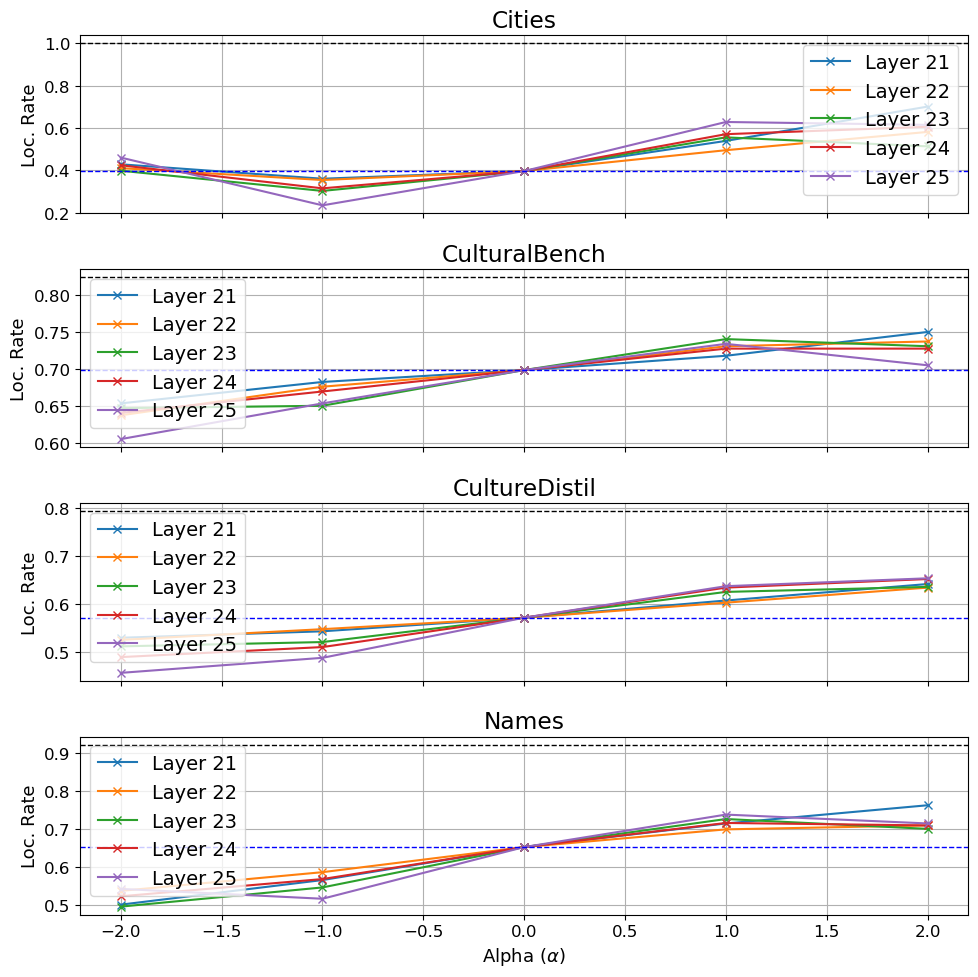

In [71]:
import matplotlib.pyplot as plt

title_map = {"cities":"Cities", "names":"Names", "culturedistil":"CultureDistil", "culturebench":"CulturalBench"}

query = "lang!='English'"
disp_df = steer_df.query(query + " and (vector=='enmicro' or vector=='none')").copy()
hinted_subs = hinted.query(query)


# Find top 4 layers with the largest maximum rate across all alphas for each src
colors = plt.cm.tab10.colors
layer_color_map = {}
for i, layer in enumerate(disp_df["layer"].unique()):
    layer_color_map[layer] = colors[i % len(colors)]
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

top_layers = {}
for src, group in disp_df.groupby("subtask"):
    max_rates = group.groupby("layer")["local_ans"].sum()
    #top_layers[src] = max_rates.nlargest(4).index.tolist()
    top_layers[src] = [21,22,23,24,25]

fig, axes = plt.subplots(len(disp_df["subtask"].unique()), 1, figsize=(10, 10), sharex=True)

for ax, (src, group) in zip(axes, disp_df.groupby("subtask")):
    for layer, layer_group in group.groupby("layer"):
        if layer in top_layers[src]:
            layer_group.groupby("alpha")["local_ans"].mean().plot(
                y="local", ax=ax, label=f"Layer {layer}", marker='x', color=layer_color_map[layer]
            )
    ax.set_title(title_map[src])
    ax.set_ylabel("Loc. Rate")
    hinted_ratio = hinted_subs.query("subtask==@src")["local_ans"].mean()
    ax.axhline(hinted_ratio, color='black', linestyle='--', linewidth=1)

    base_local_ans_rate = group.query("alpha==0")["local_ans"].mean()
    ax.axhline(base_local_ans_rate, color='blue', linestyle='--', linewidth=1)
    
    #ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.legend(title="")
    ax.grid(True)

axes[-1].set_xlabel("Alpha ($\\alpha$)")
plt.tight_layout()
plt.show()

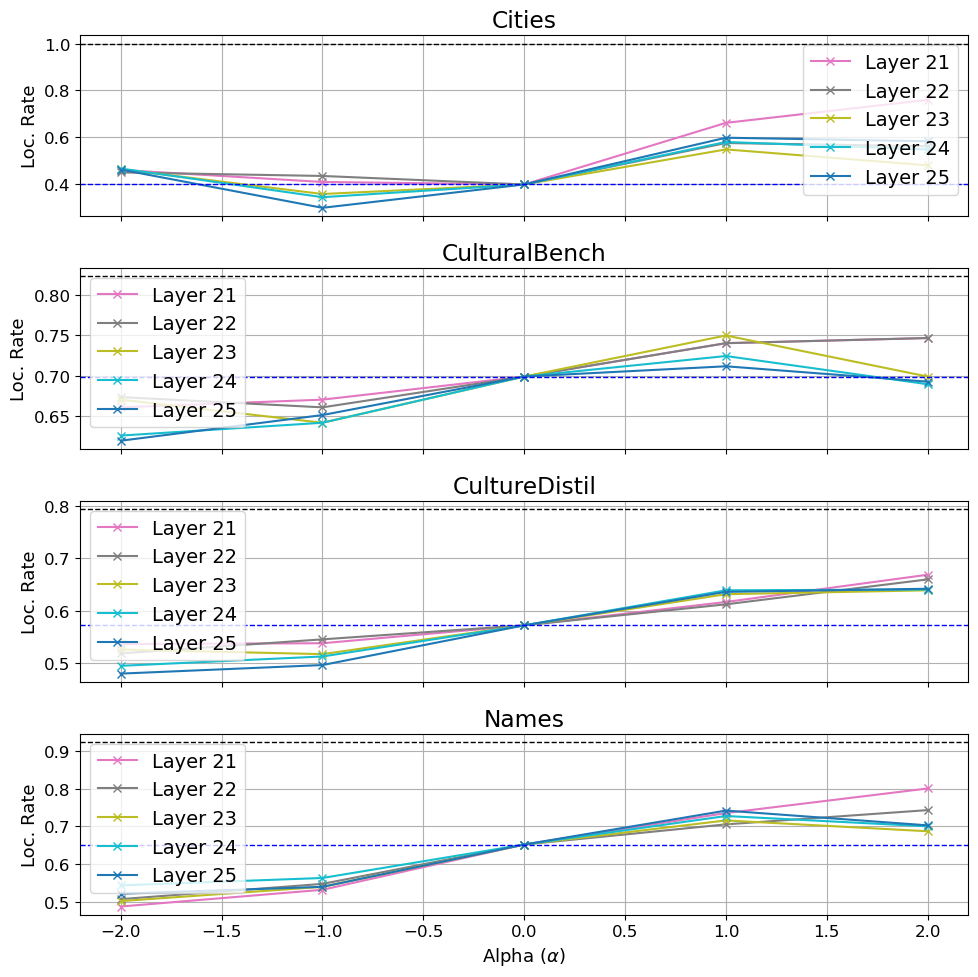

In [107]:
import matplotlib.pyplot as plt

title_map = {"cities":"Cities", "names":"Names", "culturedistil":"CultureDistil", "culturebench":"CulturalBench"}

query = "lang!='English'"
disp_df = steer_df.query(query + " and (vector=='names' or vector=='none')").copy()
hinted_subs = hinted.query(query)


# Find top 4 layers with the largest maximum rate across all alphas for each src
colors = plt.cm.tab10.colors
layer_color_map = {}
for i, layer in enumerate(disp_df["layer"].unique()):
    layer_color_map[layer] = colors[i % len(colors)]
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

top_layers = {}
for src, group in disp_df.groupby("subtask"):
    max_rates = group.groupby("layer")["local_ans"].sum()
    #top_layers[src] = max_rates.nlargest(4).index.tolist()
    top_layers[src] = [21,22,23,24,25]

fig, axes = plt.subplots(len(disp_df["subtask"].unique()), 1, figsize=(10, 10), sharex=True)

for ax, (src, group) in zip(axes, disp_df.groupby("subtask")):
    for layer, layer_group in group.groupby("layer"):
        if layer in top_layers[src]:
            layer_group.groupby("alpha")["local_ans"].mean().plot(
                y="local", ax=ax, label=f"Layer {layer}", marker='x', color=layer_color_map[layer]
            )
    ax.set_title(title_map[src])
    ax.set_ylabel("Loc. Rate")
    hinted_ratio = hinted_subs.query("subtask==@src")["local_ans"].mean()
    ax.axhline(hinted_ratio, color='black', linestyle='--', linewidth=1)

    base_local_ans_rate = group.query("alpha==0")["local_ans"].mean()
    ax.axhline(base_local_ans_rate, color='blue', linestyle='--', linewidth=1)
    
    #ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.legend(title="")
    ax.grid(True)

axes[-1].set_xlabel("Alpha ($\\alpha$)")
plt.tight_layout()
plt.show()

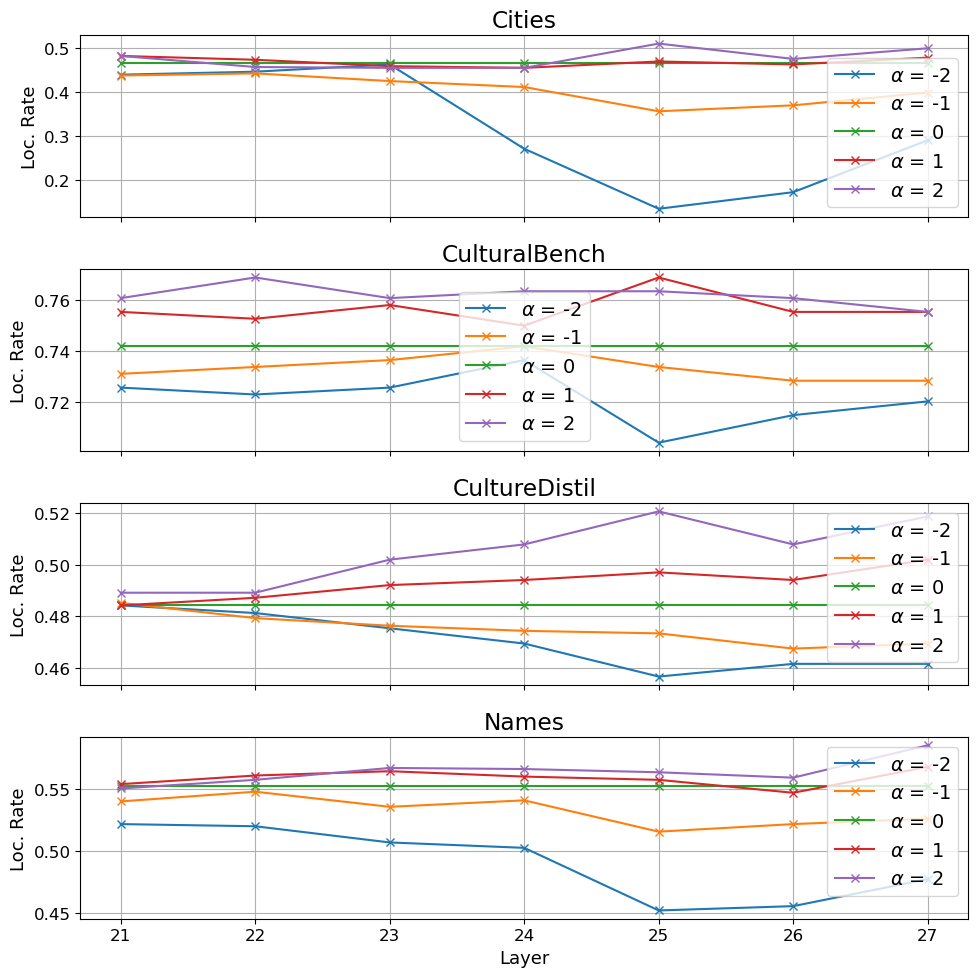

In [32]:
import matplotlib.pyplot as plt

title_map = {"cities":"Cities", "names":"Names", 
             "culturedistil":"CultureDistil", 
             "culturebench":"CulturalBench"}
            

query = "lang=='English'"
disp_df = steer_df.query(query + " and (vector=='transuniversal' or vector=='none')").copy()
hinted_subs = hinted.query(query)

# You already computed top_layers, but if you still want 
# to restrict to them, keep the code. Otherwise, remove it or comment it out.
top_layers = {}
for src, group in disp_df.groupby("subtask"):
    max_rates = group.groupby("layer")["local_ans"].sum()
    top_layers[src] = max_rates.nlargest(4).index.tolist()

# Set up a color map for alpha values (instead of layers)
colors = plt.cm.tab10.colors
unique_alphas = sorted(disp_df["alpha"].unique())
alpha_color_map = {alpha: colors[i % len(colors)]
                   for i, alpha in enumerate(unique_alphas)}

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

# Create a subplot per subtask
subtasks = disp_df["subtask"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(10, 10), sharex=True)

for ax, (src, group) in zip(axes, disp_df.groupby("subtask")):
    # If you still only want the "top 4 layers," filter the data:
    #group = group[group["layer"].isin(top_layers[src])]
    
    # Now group by alpha, then plot layer vs. mean local_ans
    for alpha, alpha_group in group.groupby("alpha"):
        mean_rates = alpha_group.groupby("layer")["local_ans"].mean()
        # Plot: x = layer index, y = mean rate
        mean_rates.plot(
            ax=ax, 
            label=f"$\\alpha$ = {alpha}", 
            marker='x',
            color=alpha_color_map[alpha]
        )

    # Horizontal lines for reference
    hinted_ratio = hinted_subs.query("subtask==@src")["local_ans"].mean()
    #ax.axhline(hinted_ratio, color='black', linestyle='--', linewidth=1, 
               #label="Hinted Mean")
    
    base_local_ans_rate = group.query("alpha==0")["local_ans"].mean()
    #ax.axhline(base_local_ans_rate, color='blue', linestyle='--', linewidth=1,
    #           label="Alpha 0 Mean")
    
    ax.set_title(title_map[src])
    ax.set_ylabel("Loc. Rate")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Layer")
plt.tight_layout()
plt.show()


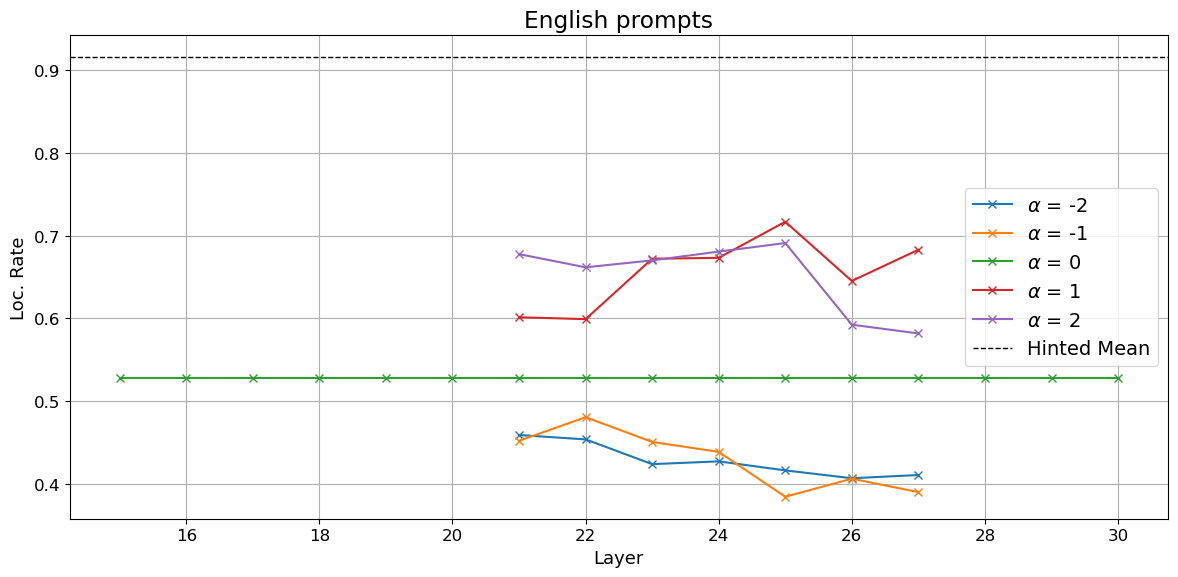

In [104]:
import matplotlib.pyplot as plt

title_map = {"cities":"Cities", "names":"Names", 
             "culturedistil":"CultureDistil", 
             "culturebench":"CulturalBench"}
            

query = "lang=='English'"
disp_df = steer_df.query(query + " and (vector=='pertask' or vector=='none')").copy()
disp_df["title"] = disp_df["lang"].apply(lambda x: "English prompts" if x == "English" else "Translated prompts")
hinted_subs = hinted.query(query)

# You already computed top_layers, but if you still want 
# to restrict to them, keep the code. Otherwise, remove it or comment it out.
top_layers = {}
for src, group in disp_df.groupby("subtask"):
    max_rates = group.groupby("layer")["local_ans"].sum()
    top_layers[src] = max_rates.nlargest(4).index.tolist()

# Set up a color map for alpha values (instead of layers)
colors = plt.cm.tab10.colors
unique_alphas = sorted(disp_df["alpha"].unique())
alpha_color_map = {alpha: colors[i % len(colors)]
                   for i, alpha in enumerate(unique_alphas)}

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

# Create a subplot per subtask
subtasks = disp_df["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(12, 6), sharex=True)
if type(axes) != list:
    axes = [axes]
for ax, (src, group) in zip(axes, disp_df.groupby("title")):
    # If you still only want the "top 4 layers," filter the data:
    #group = group[group["layer"].isin(top_layers[src])]
    
    # Now group by alpha, then plot layer vs. mean local_ans
    for alpha, alpha_group in group.groupby("alpha"):
        mean_rates = alpha_group.groupby("layer")["local_ans"].mean()
        # Plot: x = layer index, y = mean rate
        mean_rates.plot(
            ax=ax, 
            label=f"$\\alpha$ = {alpha}", 
            marker='x',
            color=alpha_color_map[alpha]
        )

    # Horizontal lines for reference
    hinted_ratio = hinted_subs.query("lang!=@src")["local_ans"].mean()
    ax.axhline(hinted_ratio, color='black', linestyle='--', linewidth=1, 
               label="Hinted Mean")
    
    base_local_ans_rate = group.query("alpha==0")["local_ans"].mean()
    #ax.axhline(base_local_ans_rate, color='blue', linestyle='--', linewidth=1,
    #           label="Alpha 0 Mean")
    
    ax.set_title(src)
    ax.set_ylabel("Loc. Rate")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Layer")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

title_map = {"cities":"Cities", "names":"Names", "culturedistil":"CultureDistil", "culturebench":"CulturalBench"}

query = "lang!='English'"
disp_df = steer_df.query(query).copy()
hinted_subs = hinted.query(query)


# Find top 4 layers with the largest maximum rate across all alphas for each src
colors = plt.cm.tab10.colors
layer_color_map = {}
for i, layer in enumerate(disp_df["layer"].unique()):
    layer_color_map[layer] = colors[i % len(colors)]
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

top_layers = {}
for src, group in disp_df.groupby("subtask"):
    max_rates = group.groupby("layer")["local_ans"].sum()
    top_layers[src] = max_rates.nlargest(4).index.tolist()
    #top_layers[src] = [21,22,23,24,25]

fig, axes = plt.subplots(len(disp_df["subtask"].unique()), 1, figsize=(10, 10), sharex=True)

for ax, (src, group) in zip(axes, disp_df.groupby("subtask")):
    for layer, layer_group in group.groupby("layer"):
        if layer in top_layers[src]:
            layer_group.groupby("alpha")["local_ans"].mean().plot(
                y="local", ax=ax, label=f"Layer {layer}", marker='x', color=layer_color_map[layer]
            )
    ax.set_title(title_map[src])
    ax.set_ylabel("Loc. Rate")
    hinted_ratio = hinted_subs.query("subtask==@src")["local_ans"].mean()
    ax.axhline(hinted_ratio, color='black', linestyle='--', linewidth=1)

    base_local_ans_rate = group.query("alpha==0")["local_ans"].mean()
    ax.axhline(base_local_ans_rate, color='blue', linestyle='--', linewidth=1)
    
    #ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.legend(title="")
    ax.grid(True)

axes[-1].set_xlabel("Alpha ($\\alpha$)")
plt.tight_layout()
plt.show()

In [49]:
# Filter for English examples
english_examples = steer_df.query("lang != 'xEnglish' and vector == 'enuniversal'")

# Group by alpha and layer, and calculate the mean localization rate
grouped = english_examples.groupby(['alpha', 'layer'])['local_ans'].mean().reset_index()

# Find the group with the highest localization rate
best_group = grouped.loc[grouped['local_ans'].idxmax()]

best_alpha = best_group['alpha']
best_layer = best_group['layer']

print(f"Best alpha: {best_alpha}, Best layer: {best_layer}")
# Calculate performance for each task
# Calculate delta localization rate
english_examples["delta_local"] = english_examples["local_ans"] - english_examples["local_ans_base"]

# Calculate performance for each task
task_performance = english_examples.query("alpha==@best_alpha and layer == @best_layer").groupby('subtask').agg(
    localization_rate=('local_ans', 'mean'),
    delta_localization_rate=('delta_local', 'mean')
).reset_index()
task_performance.columns = ['subtask', 'localization_rate', 'delta_localization_rate']

print("Performance for each task:")
print(task_performance)

Best alpha: 2.0, Best layer: 27.0
Performance for each task:
         subtask  localization_rate  delta_localization_rate
0         cities           0.597633                 0.158580
1   culturebench           0.747076                 0.024854
2  culturedistil           0.573547                 0.054567
3          names           0.649715                 0.057602


/tmp/ipykernel_1212/1479180178.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_examples["delta_local"] = english_examples["local_ans"] - english_examples["local_ans_base"]


In [41]:
hinted_perf = hinted.groupby("subtask")["local_ans"].mean()

In [ ]:
comp_table = task_performance.merge(best_groups_per_task, on="subtask", suffixes=("_names", "_pertask"))
comp_table["delta_localization_rate_pertask"] = - comp_table["delta_localization_rate_pertask"]
comp_table = comp_table.merge(hinted_perf, left_on="subtask", right_index=True, suffixes=("", "_hinted"))

comp_table = comp_table.round(2)
comp_table.drop(columns=["alpha", "layer"], inplace=True)
comp_table.rename(columns={"localization_rate": "names vector localization rate","local_ans": "per-task vector localization rate", "local_ans_hinted": "localization rate w hint"}, inplace=True)
print(comp_table)


,subtask,localization_rate,delta_localization_rate_names,alpha,layer,local_ans,delta_localization_rate_pertask,local_ans_hinted
0,cities,0.84,0.40,1,25,0.73,0.29,1.00
1,culturebench,0.77,0.04,2,24,0.77,0.05,0.86
2,culturedistil,0.68,0.16,3,25,0.69,0.17,0.82
3,names,0.82,0.22,3,21,0.82,0.22,0.92


In [42]:
# Filter for English examples
english_examples = steer_df.query("lang != 'XEnglish' and (vector == 'enmicro' or vector=='none')")

# Group by task, alpha, and layer, and calculate the mean localization rate
grouped_task = english_examples.groupby(['subtask', 'alpha', 'layer'])['local_ans'].mean().reset_index()

# Find the group with the highest localization rate for each task
best_groups_per_task = grouped_task.loc[grouped_task.groupby('subtask')['local_ans'].idxmax()]

# Calculate delta localization rate for each task
best_groups_per_task["delta_localization_rate"] = best_groups_per_task.apply(
    lambda row: english_examples.query(f"subtask == '{row['subtask']}' and layer == {row['layer']} and alpha == 0")["local_ans"].mean() - row["local_ans"], axis=1
)

# Print the best alpha, layer, localization rate, and delta localization rate for each task
for _, row in best_groups_per_task.iterrows():
    print(f"Task: {row['subtask']}, Best alpha: {row['alpha']}, Best layer: {row['layer']}, Localization rate: {row['local_ans']}, Delta Localization rate: {row['delta_localization_rate']}")


Task: cities, Best alpha: 2, Best layer: 25, Localization rate: 0.772189349112426, Delta Localization rate: -0.3331360946745562
Task: culturebench, Best alpha: 2, Best layer: 23, Localization rate: 0.7646198830409356, Delta Localization rate: -0.042397660818713434
Task: culturedistil, Best alpha: 2, Best layer: 25, Localization rate: 0.6298932384341637, Delta Localization rate: -0.11091340450771048
Task: names, Best alpha: 2, Best layer: 21, Localization rate: 0.7368967306694344, Delta Localization rate: -0.14478463933575514


In [ ]:
best_layer = 25

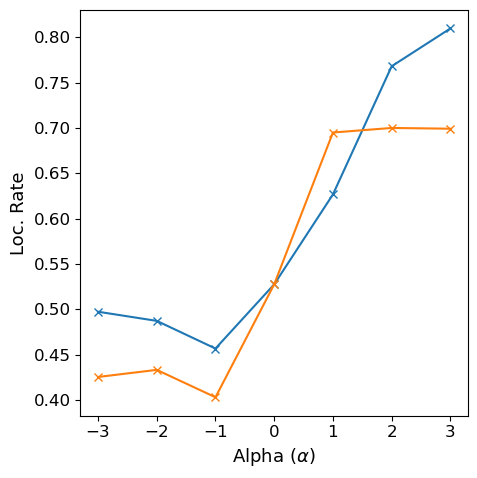

In [54]:
import matplotlib.pyplot as plt

names_best_df = steer_df.query("(vector == 'names' or vector=='none') and layer == 21")
pertask_best_df = pd.concat(best_layer_curves).copy()
#hinted_subs = hinted.query()
fig, ax = plt.subplots(figsize=(5, 5))

names_best_df.query("lang == 'English'").groupby("alpha")["local_ans"].mean().plot(
                y="local", ax=ax, label=f"per-task", marker='x',
            )

pertask_best_df.query("lang == 'English'").groupby("alpha")["local_ans"].mean().plot(
                y="local", ax=ax, label=f"names", marker='x',
            )
ax.set_ylabel("Loc. Rate")
#hinted_ratio = hinted_subs.query("subtask==@src")["local_ans"].mean()
#   ax.axhline(hinted_ratio, color='black', linestyle='--', linewidth=1)

ax.set_xlabel("Alpha ($\\alpha$)")
plt.tight_layout()
plt.show()

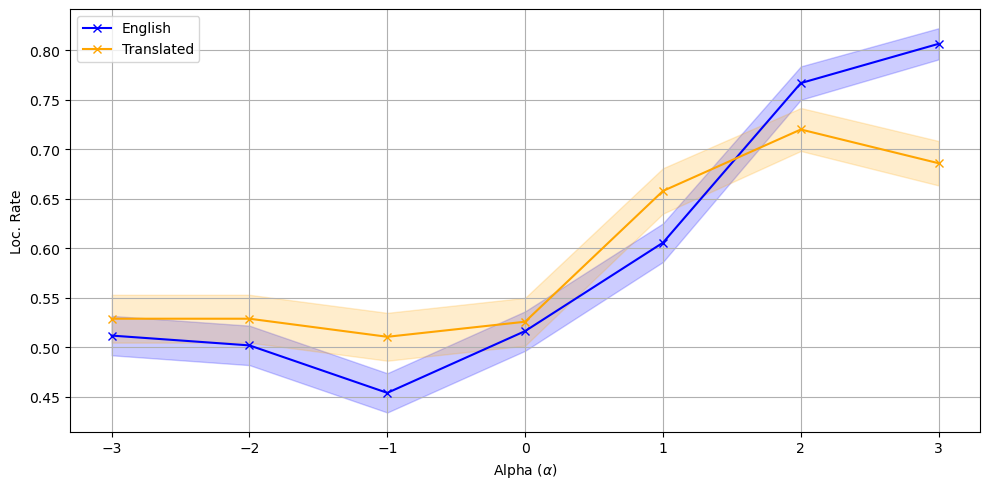

In [ ]:
from tools.contrastiveact import plot_local_rate_by_alpha

fig, ax = plt.subplots(figsize=(10, 5))
plot_local_rate_by_alpha(names_best_df, english_label="English", other_label="Translated", ax=ax)

hinted_ratio = hinted_subs.query("subtask==@src")["local_ans"].mean()
#   ax.axhline(hinted_ratio, color='black', linestyle='--', linewidth=1)

plt.show()

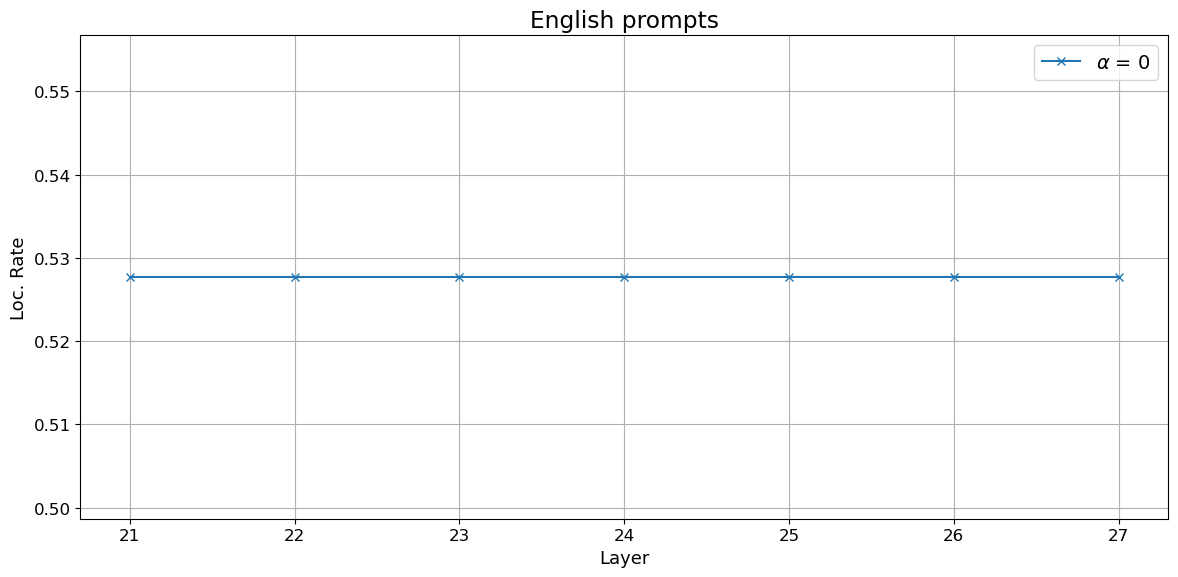

In [ ]:
import matplotlib.pyplot as plt

title_map = {"cities":"Cities", "names":"Names", 
             "culturedistil":"CultureDistil", 
             "culturebench":"CulturalBench"}
            

query = "lang=='English'"
disp_df = steer_df.query(query + " and (vector=='enmicro' or vector=='none')").copy()
disp_df["title"] = disp_df["lang"].apply(lambda x: "English prompts" if x == "English" else "Translated prompts")
hinted_subs = hinted.query(query)

# You already computed top_layers, but if you still want 
# to restrict to them, keep the code. Otherwise, remove it or comment it out.
top_layers = {}
for src, group in disp_df.groupby("subtask"):
    max_rates = group.groupby("layer")["local_ans"].sum()
    top_layers[src] = max_rates.nlargest(4).index.tolist()

# Set up a color map for alpha values (instead of layers)
colors = plt.cm.tab10.colors
unique_alphas = sorted(disp_df["alpha"].unique())
alpha_color_map = {alpha: colors[i % len(colors)]
                   for i, alpha in enumerate(unique_alphas)}

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

# Create a subplot per subtask
subtasks = disp_df["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(12, 6), sharex=True)
if type(axes) != list:
    axes = [axes]
for ax, (src, group) in zip(axes, disp_df.groupby("title")):
    # If you still only want the "top 4 layers," filter the data:
    #group = group[group["layer"].isin(top_layers[src])]
    
    # Now group by alpha, then plot layer vs. mean local_ans
    for alpha, alpha_group in group.groupby("alpha"):
        mean_rates = alpha_group.groupby("layer")["local_ans"].mean()
        # Plot: x = layer index, y = mean rate
        mean_rates.plot(
            ax=ax, 
            label=f"$\\alpha$ = {alpha}", 
            marker='x',
            color=alpha_color_map[alpha]
        )
    
    ax.set_title(src)
    ax.set_ylabel("Loc. Rate")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Layer")
plt.tight_layout()
plt.show()

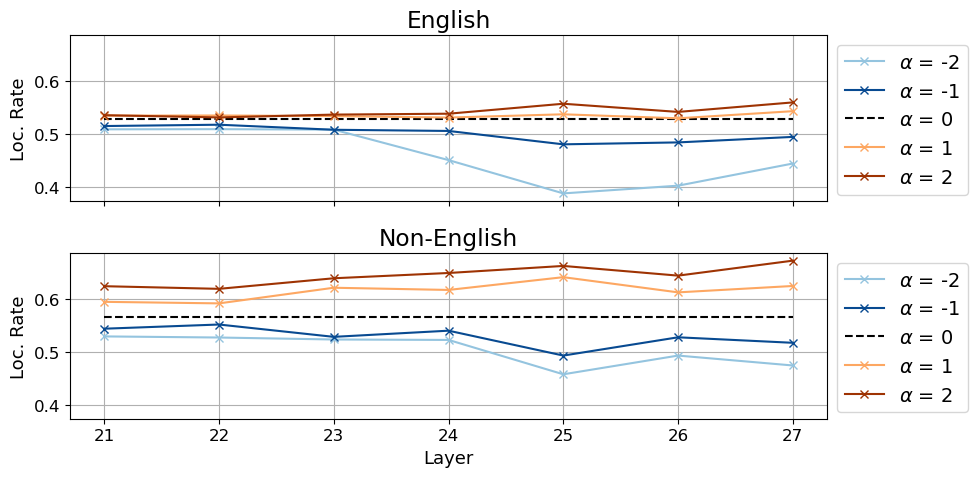

In [52]:
import numpy as np
import matplotlib.pyplot as plt

title_map = {
    "cities": "Cities",
    "names": "Names", 
    "culturedistil": "CultureDistil",
    "culturebench": "CulturalBench"
}

query = "lang!='xEnglish' and alpha<3 and alpha>-3"
disp_df = steer_df.query(query + " and (vector=='transuniversal' or vector=='none')").copy()
disp_df["title"] = disp_df["lang"].apply(lambda x: "English" if x == "English" else "Non-English")

# If you still need hinted_subs:
# hinted_subs = hinted.query(query)

########################################################################
# 1) Identify unique alpha values and split into negative vs positive
########################################################################
all_alphas = sorted(disp_df["alpha"].unique())  # ascending order
negative_alphas = [a for a in all_alphas if a < 0]
positive_alphas = [a for a in all_alphas if a > 0]

########################################################################
# 2) Create color mappings
#    - For negative alphas: use Blues (from lighter to darker or vice versa).
#    - For positive alphas: use Oranges (from lighter to darker or vice versa).
########################################################################
# You can adjust np.linspace(...) ranges or pick another colormap if you prefer.
neg_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(negative_alphas)))
pos_colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(positive_alphas)))

alpha_color_map = {}
for alpha_val, color_val in zip(negative_alphas, neg_colors):
    alpha_color_map[alpha_val] = color_val
for alpha_val, color_val in zip(positive_alphas, pos_colors):
    alpha_color_map[alpha_val] = color_val

########################################################################
# 3) Create subplots, one per "title" group
########################################################################
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12, 
    'axes.labelsize': 13
})

subtasks = disp_df["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(10, 5), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]  # Ensure we have an iterable of axes

########################################################################
# 4) Iterate over each subplot (by "title") and plot mean ± 95% CI
#    for each alpha, in ascending order of alpha.
########################################################################
for ax, (src, group) in zip(axes, disp_df.groupby("title")):
    # If you only want top layers, you can filter here; otherwise skip
    # group = group[group["layer"].isin(top_layers[src])] 
    
    # Sort alpha in ascending order so the legend goes from negative -> positive
    for alpha_val in sorted(group["alpha"].unique()):
        # Skip alpha=0 if you do not want it (or handle it separately)
        if alpha_val == 0:
            pass
        
        alpha_grp = group[group["alpha"] == alpha_val]
        
        # For each layer, we gather all local_ans values
        layer_groups = alpha_grp.groupby("layer")["local_ans"].apply(list)
        
        # Sort layers
        layers = sorted(layer_groups.index)
        means, ci_low, ci_high = [], [], []
        
        for lyr in layers:
            arr = np.array(layer_groups.loc[lyr], dtype=float)
            m = arr.mean()
            # Standard error
            sem = arr.std(ddof=1) / np.sqrt(len(arr))
            # 95% CI ~ mean ± 1.96*SEM
            ci = 1.96 * sem
            
            means.append(m)
            ci_low.append(m - ci)
            ci_high.append(m + ci)
        
        

        # Plot line (mean) and fill for CI
        if alpha_val == 0:
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                linestyle="dashed",
                color="black"
            )
        else:
            # Get color for current alpha
            color = alpha_color_map[alpha_val]
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                color=color,
                marker='x'
            )
        '''
        ax.fill_between(
            layers, 
            ci_low, 
            ci_high,
            color=color, 
            alpha=0.2
        )
        '''
        
    ax.set_title(src)
    ax.set_ylabel("Loc. Rate")
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    ax.plot()

axes[-1].set_xlabel("Layer")
plt.tight_layout()
plt.show()



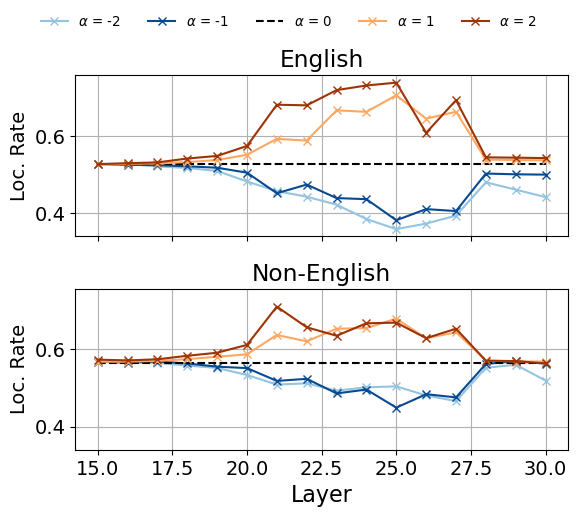

In [124]:
import numpy as np
import matplotlib.pyplot as plt

title_map = {
    "cities": "Cities",
    "names": "Names", 
    "culturedistil": "CultureDistil",
    "culturebench": "CulturalBench"
}

query = "lang!='xEnglish' and alpha<3 and alpha>-3"
disp_df = steer_df.query(query + " and (vector=='enmicro' or vector=='none')").copy()
disp_df["title"] = disp_df["lang"].apply(lambda x: "English" if x == "English" else "Non-English")

# If you still need hinted_subs:
# hinted_subs = hinted.query(query)

########################################################################
# 1) Identify unique alpha values and split into negative vs positive
########################################################################
all_alphas = sorted(disp_df["alpha"].unique())  # ascending order
negative_alphas = [a for a in all_alphas if a < 0]
positive_alphas = [a for a in all_alphas if a > 0]

########################################################################
# 2) Create color mappings
#    - For negative alphas: use Blues (from lighter to darker or vice versa).
#    - For positive alphas: use Oranges (from lighter to darker or vice versa).
########################################################################
# You can adjust np.linspace(...) ranges or pick another colormap if you prefer.
neg_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(negative_alphas)))
pos_colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(positive_alphas)))

alpha_color_map = {}
for alpha_val, color_val in zip(negative_alphas, neg_colors):
    alpha_color_map[alpha_val] = color_val
for alpha_val, color_val in zip(positive_alphas, pos_colors):
    alpha_color_map[alpha_val] = color_val

########################################################################
# 3) Create subplots, one per "title" group
########################################################################
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12, 
    'axes.labelsize': 13
})

subtasks = disp_df["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(6, 5), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]  # Ensure we have an iterable of axes

########################################################################
# 4) Iterate over each subplot (by "title") and plot mean ± 95% CI
#    for each alpha, in ascending order of alpha.
########################################################################
for ax, (src, group) in zip(axes, disp_df.groupby("title")):
    # If you only want top layers, you can filter here; otherwise skip
    # group = group[group["layer"].isin(top_layers[src])] 
    
    # Sort alpha in ascending order so the legend goes from negative -> positive
    for alpha_val in sorted(group["alpha"].unique()):
        # Skip alpha=0 if you do not want it (or handle it separately)
        if alpha_val == 0:
            pass
        
        alpha_grp = group[group["alpha"] == alpha_val]
        
        # For each layer, we gather all local_ans values
        layer_groups = alpha_grp.groupby("layer")["local_ans"].apply(list)
        
        # Sort layers
        layers = sorted(layer_groups.index)
        means, ci_low, ci_high = [], [], []
        
        for lyr in layers:
            arr = np.array(layer_groups.loc[lyr], dtype=float)
            m = arr.mean()
            # Standard error
            sem = arr.std(ddof=1) / np.sqrt(len(arr))
            # 95% CI ~ mean ± 1.96*SEM
            ci = 1.96 * sem
            
            means.append(m)
            ci_low.append(m - ci)
            ci_high.append(m + ci)
        
        

        # Plot line (mean) and fill for CI
        if alpha_val == 0:
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                linestyle="dashed",
                color="black"
            )
        else:
            # Get color for current alpha
            color = alpha_color_map[alpha_val]
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                color=color,
                marker='x'
            )
        '''
        ax.fill_between(
            layers, 
            ci_low, 
            ci_high,
            color=color, 
            alpha=0.2
        )
        '''
        
    ax.set_title(src)
    ax.set_ylabel("Loc. Rate")
    ax.grid(True)
    #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    
    ax.plot()
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

axes[-1].set_xlabel("Layer")

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='x-small', frameon=False)
# Reduce whitespace and lower the font size of the legend
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='x-small')
# Make legend small
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels), fontsize='small')
# Make font of tick params larger
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

# Make x label and y label font size larger
axes[-1].set_xlabel("Layer", fontsize=16)
for ax in axes:
    ax.set_ylabel("Loc. Rate", fontsize=14)
# Move legend to the top
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels))
plt.tight_layout(pad=1.0)
# Save the figure
fig.savefig("steering_eng_noneng_large.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [61]:
steer_df["vector"].unique()

array(['enuniversal', 'transuniversal', 'enmicro', 'transmicro', 'none'],
      dtype=object)

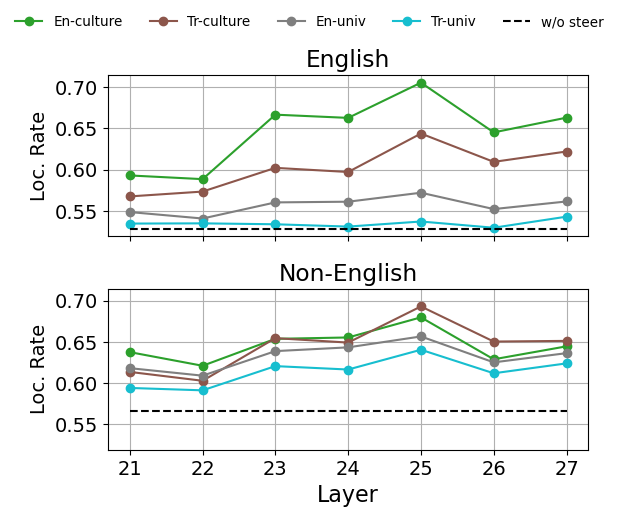

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

title_map = {
    "cities": "Cities",
    "names": "Names", 
    "culturedistil": "CultureDistil",
    "culturebench": "CulturalBench"
}

########################################################
# 0) Create disp_df without restricting vectors
########################################################
# (Remove the `(vector=='enuniversal' or vector=='none')` part)
query = "lang!='xEnglish' and alpha<3 and alpha>-3 and layer<28 and layer>20"
disp_df = steer_df.query(query).copy()

# Optional: If you still want a column marking 'English' vs 'Non-English'
disp_df["title"] = disp_df["lang"].apply(
    lambda x: "English" if x == "English" else "Non-English"
)

########################################################
# 1) Filter down to alpha=0 only
########################################################
disp_df_alpha0 = disp_df[disp_df["alpha"] == 1].copy()

########################################################
# 2) Create subplots by "title" group (if you want them)
#    If you only want a single plot, skip grouping by "title".
########################################################
subtasks = disp_df_alpha0["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(6, 5), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]  # Ensure an iterable of axes if there's only one subplot

# Define a color mapping for each vector type (5 total)
vector_types = ["none", "enmicro", "transmicro", "enuniversal", "transuniversal"]
colors = plt.cm.tab10(np.linspace(0, 1, len(vector_types)))
vector_color_map = dict(zip(vector_types, colors))

# Update vec_title for more compact labels

vec_title = {
    "enmicro": "per-culture",
    "transmicro": "Tr-culture",
    "enuniversal": "En-univ",
    "transuniversal": "Tr-univ",
}

vec_title_x = {"enmicro": "En - per culture",
             "transmicro": "Tr. - per culture",
             "enuniversal": "En - universal",
             "transuniversal": "Tr. - universal",}
# Set up some style preferences
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

########################################################
# 3) Iterate over each subplot (by "title") and plot 
#    mean ± 95% CI for each vector type.
########################################################
for ax, (title_value, group) in zip(axes, disp_df_alpha0.groupby("title")):
    
    # group is already filtered to alpha=0 and the current 'title'
    # Now group further by vector
    for vec in vector_types:
        vec_df = group[group["vector"] == vec]
        if vec_df.empty:
            continue
        
        # Group by layer to get list of local_ans values
        layer_groups = vec_df.groupby("layer")["local_ans"].apply(list)
        
        # Sort layers numerically
        layers = sorted(layer_groups.index)
        
        means, ci_low, ci_high = [], [], []
        
        for lyr in layers:
            arr = np.array(layer_groups.loc[lyr], dtype=float)
            m = arr.mean()
            # Standard error of the mean
            sem = arr.std(ddof=1) / np.sqrt(len(arr))
            ci = 1.96 * sem  # 95% CI ~ ±1.96 * SEM
            
            means.append(m)
            ci_low.append(m - ci)
            ci_high.append(m + ci)
        
        # Plot line and fill for CI
        color = vector_color_map[vec]
        ax.plot(
            layers, means,
            label=vec_title[vec], 
            color=color,
            marker='o'
        )
        #ax.fill_between(layers, ci_low, ci_high, color=color, alpha=0.2)
    # Plot dashed line for alpha=0 per layer in disp_df
    alpha0_group = disp_df[(disp_df["alpha"] == 0) & (disp_df["title"]==title_value)].groupby("layer")["local_ans"].mean()
    ax.plot(
        alpha0_group.index, alpha0_group.values,
        label="w/o steer",
        linestyle="dashed",
        color="black"
    )
    ax.plot()
    ax.set_title(title_value)
    ax.set_ylabel("Loc. Rate")  # or "Loc. Rate"
    ax.grid(True)
    # Add a single legend for the entire figure
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
#fig.legend(handles, labels, loc='right', bbox_to_anchor=(1, 1))
    #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[-1].set_xlabel("Layer")
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='x-small', frameon=False)

#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='x-small', frameon=False)
# Reduce whitespace and lower the font size of the legend
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='x-small')
# Make legend small
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels), fontsize='small')
# Make font of tick params larger
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

# Make x label and y label font size larger
axes[-1].set_xlabel("Layer", fontsize=16)
for ax in axes:
    ax.set_ylabel("Loc. Rate", fontsize=14)
# Move legend to the top
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels))
plt.tight_layout(pad=1.0)
# Save the figure

plt.tight_layout()
plt.show()
fig.savefig("universal_vs_culturespecific.pdf", dpi=300, bbox_inches='tight')

In [49]:
best_alpha = 5
best_layer = 22

query = "lang=='English'"

# Filter the dataframe for the best alpha
best_alpha_df = steer_df.query("alpha == @best_alpha and layer == @best_layer")

# Group by subtask and calculate the mean localization rate
performance_by_subtask = best_alpha_df.query(query).groupby('subtask')['local_ans'].mean().reset_index()
hinted_rate = hinted.query(query).groupby("subtask")["local_ans"].mean().reset_index()
performance_by_subtask = performance_by_subtask.merge(hinted_rate, on="subtask", suffixes=("_steer", "_hint"))

print(performance_by_subtask)

         subtask  local_ans_steer  local_ans_hint
0         cities         0.821809        1.000000
1   culturebench         0.275000        0.576923
2  culturedistil         0.520000        0.825666
3          names         0.751572        0.911980
